<a href="https://colab.research.google.com/github/nafizfouad/BizNLP-A-Way-to-Change-the-Face-of-Business/blob/main/BizNLP_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install flair
!pip install accelerate -U

import numpy as np
import os
import random
import re
import torch
import nltk
import spacy
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from google.colab import drive
from google.colab import files
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorForTokenClassification
from transformers import BertTokenizerFast, BertForTokenClassification
from spacy.training import Example
from spacy.util import minibatch, compounding
from flair.data import Corpus, Sentence, Token
from flair.datasets import ColumnCorpus
from flair.embeddings import TransformerWordEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from flair.training_utils import EvaluationMetric
from datasets import Dataset, DatasetDict
import accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 68.0 MB/s eta

In [2]:
#2 reading data for ner
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/dataset/amazon_electronics.csv')

print(data.columns)

Mounted at /content/drive
Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'sentiment'],
      dtype='object')


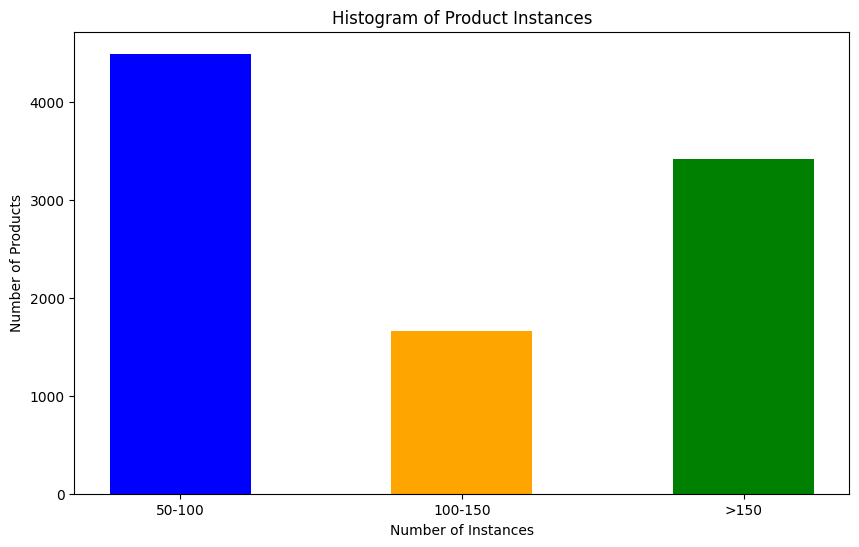

In [3]:
#3 eda on preprocessed data

data = data[data['product_title'].apply(lambda x: isinstance(x, str))]

# Count the number of instances for each product
product_counts = data['product_title'].value_counts()

# Define the bins
bins = [50, 100, 150, float('inf')]
labels = ['50-100', '100-150', '>150']

# Bin the product counts
binned_counts = pd.cut(product_counts, bins=bins, labels=labels, right=False)

# Count the number of products in each bin
hist_counts = binned_counts.value_counts().sort_index()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(hist_counts.index, hist_counts.values, width=0.5, color=['blue', 'orange', 'green', 'red'])
plt.title('Histogram of Product Instances')
plt.xlabel('Number of Instances')
plt.ylabel('Number of Products')
plt.savefig('product_instances_histogram.png')
plt.show()


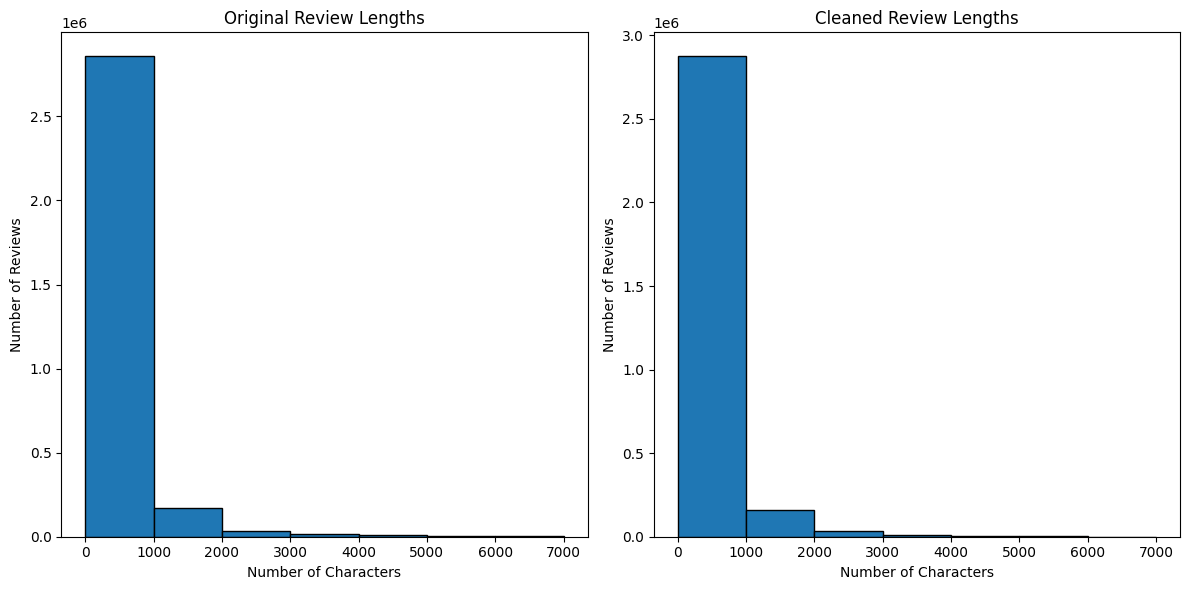

In [4]:
#4 data cleaning ner
data = data[data['review_body'].apply(lambda x: isinstance(x, str))]
def clean_text(text):
    # Remove special characters, dots, brackets, etc.
    text = re.sub(r'[^A-Za-z\s]', '', text)
    return text

# Save original lengths of review texts
data['original_length'] = data['review_body'].apply(len)

# Apply the function to remove special characters
data['review_body'] = data['review_body'].apply(clean_text)

# Save cleaned lengths of review texts
data['cleaned_length'] = data['review_body'].apply(len)

# Plot the distribution of lengths before and after cleaning
bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(data['original_length'], bins=bins, edgecolor='black')
plt.title('Original Review Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Number of Reviews')
plt.xticks(bins)

plt.subplot(1, 2, 2)
plt.hist(data['cleaned_length'], bins=bins, edgecolor='black')
plt.title('Cleaned Review Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Number of Reviews')
plt.xticks(bins)

plt.tight_layout()
plt.savefig('review_lengths_comparison.png')
plt.show()


Number of rows in the final dataset: 8434
  marketplace  customer_id       review_id  product_id  product_parent  \
0          US     23435662   RA1I7YAGZ1MAF  B007OYAVLI       942929499   
1          US     15981773  R2SMD27P0Z31ZN  B007OY66IU       942929499   
2          US     48286725  R14UKUGO2HYTG5  B007OY66IU       942929499   
3          US     17251177   ROIY6V1XD6EKH  B007OY5V68       942929499   
4          US      1256895  R29ESDN8RH0BUR  B007OYAVLI       942929499   

                                       product_title product_category  \
0  (NEW) AYL Portable Bluetooth Wireless Version ...      Electronics   
1  (NEW) AYL Portable Bluetooth Wireless Version ...      Electronics   
2  (NEW) AYL Portable Bluetooth Wireless Version ...      Electronics   
3  (NEW) AYL Portable Bluetooth Wireless Version ...      Electronics   
4  (NEW) AYL Portable Bluetooth Wireless Version ...      Electronics   

   star_rating  helpful_votes  total_votes vine verified_purchase  \
0    

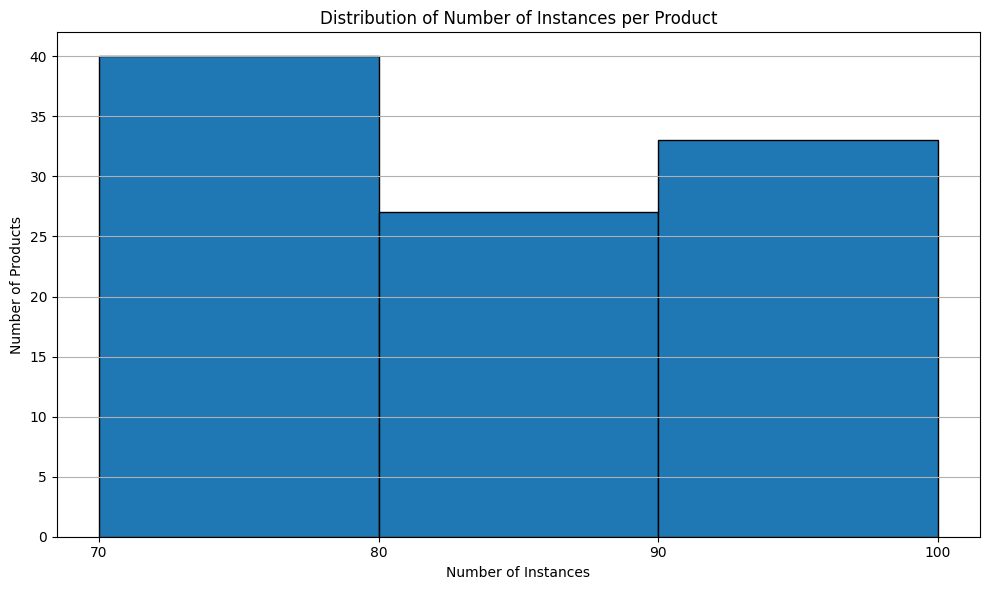

In [5]:
#5 data selection ner
top_100_products = data['product_title'].value_counts().nlargest(100).index

# Step 2: Filter the DataFrame to keep only the rows with these top 100 products
filtered_data = data[data['product_title'].isin(top_100_products)]

# Step 3: For each of these products, randomly select between 70 to 100 instances
def sample_rows(group):
    num_samples = np.random.randint(70, 101)  # Randomly choose a number between 70 and 100
    return group.sample(n=min(num_samples, len(group)), random_state=42)

final_data = filtered_data.groupby('product_title').apply(sample_rows).reset_index(drop=True)

# Check the number of rows to ensure it is close to 10000
print(f"Number of rows in the final dataset: {len(final_data)}")

# Print the first few rows to check
print(final_data.head())

instance_counts = final_data['product_title'].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(instance_counts, bins=[70, 80, 90, 100], edgecolor='black')
plt.title('Distribution of Number of Instances per Product')
plt.xlabel('Number of Instances')
plt.ylabel('Number of Products')
plt.xticks([70, 80, 90, 100])
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('instances_per_product_histogram.png')
plt.show()

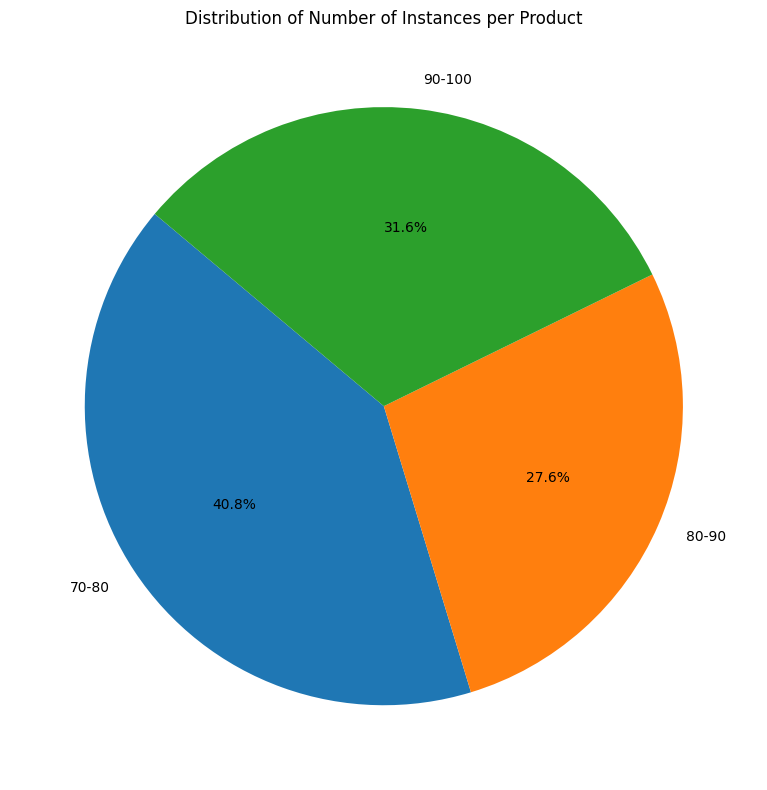

In [6]:
#5.5
bins = [70, 80, 90, 100]
labels = ['70-80', '80-90', '90-100']

# Bin the instance counts
binned_counts = pd.cut(instance_counts, bins=bins, labels=labels, right=False).value_counts().sort_index()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(binned_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Number of Instances per Product')
plt.tight_layout()
plt.savefig('instances_per_product_pie_chart.png')
plt.show()

In [7]:
#6 data preparation for ner
def insert_product_title_randomly(row):
    review = row['review_body']
    product_title = row['product_title']

    # Split review into words
    words = review.split()

    # Choose a random position to insert the product title
    insert_position = np.random.randint(0, len(words) + 1)

    # Insert the product title at the random position
    words.insert(insert_position, product_title)

    # Join words back into a single string
    return ' '.join(words)

# Apply the function to each row in the DataFrame
final_data['review_body'] = final_data.apply(insert_product_title_randomly, axis=1)

# Print the first few rows to check
print(final_data.head())
data = final_data

  marketplace  customer_id       review_id  product_id  product_parent  \
0          US     23435662   RA1I7YAGZ1MAF  B007OYAVLI       942929499   
1          US     15981773  R2SMD27P0Z31ZN  B007OY66IU       942929499   
2          US     48286725  R14UKUGO2HYTG5  B007OY66IU       942929499   
3          US     17251177   ROIY6V1XD6EKH  B007OY5V68       942929499   
4          US      1256895  R29ESDN8RH0BUR  B007OYAVLI       942929499   

                                       product_title product_category  \
0  (NEW) AYL Portable Bluetooth Wireless Version ...      Electronics   
1  (NEW) AYL Portable Bluetooth Wireless Version ...      Electronics   
2  (NEW) AYL Portable Bluetooth Wireless Version ...      Electronics   
3  (NEW) AYL Portable Bluetooth Wireless Version ...      Electronics   
4  (NEW) AYL Portable Bluetooth Wireless Version ...      Electronics   

   star_rating  helpful_votes  total_votes vine verified_purchase  \
0            5              0            0    N

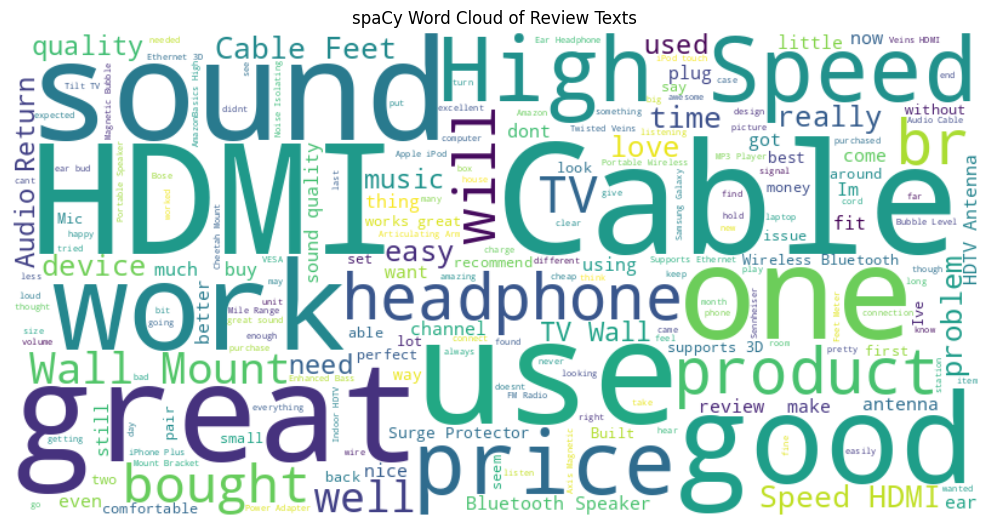

In [8]:
#7 preprocess spacy
# Function to create training data in spaCy format
from wordcloud import WordCloud
def create_spacy_training_data(row):
    text = row['review_body']
    product_name = row['product_title']
    start = text.find(product_name)
    if start == -1:
        return None
    end = start + len(product_name)
    return (text, {"entities": [(start, end, "PRODUCT")]})

# Prepare the training data
data = data.dropna(subset=['review_body', 'product_title'])
train_data = data.apply(create_spacy_training_data, axis=1).dropna()

# Split the data into training and testing sets
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Combine all the review texts for the word cloud
all_review_texts = " ".join(data['review_body'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_review_texts)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('spaCy Word Cloud of Review Texts')
plt.tight_layout()
plt.savefig('word_cloud_review_texts.png')
plt.show()

num_samples_to_visualize = 5
sample_indices = random.sample(range(len(train_data)), num_samples_to_visualize)

for i in sample_indices:
    text, annotations = train_data.iloc[i]
    entities = annotations["entities"]
    entity_strings = [f"{start},{end} ({text[start:end]})" for start, end, label in entities]
    entity_info = "; ".join(entity_strings)
    print(f"Text: {text}")
    print(f"Entities: {entity_info}")
    print("\n")

Text: Mohu Leaf 30 TV Antenna, Indoor, 30 Mile Range, Original Paper-thin, Reversible, Paintable, 4K-Ready HDTV, 10 Foot Detachable Cable, Premium Materials for Performance, USA Made, MH-110583 Gave up cable over a year ago Got one for each TV in the house Get all the main local channels plus some
Entities: 0,187 (Mohu Leaf 30 TV Antenna, Indoor, 30 Mile Range, Original Paper-thin, Reversible, Paintable, 4K-Ready HDTV, 10 Foot Detachable Cable, Premium Materials for Performance, USA Made, MH-110583)


Text: Really theres not a whole lot to say about BlueRigger Basic High Speed HDMI Cable - 6.6 Feet - Supports 4K, Ultra HD, 3D, 1080p, Ethernet and Audio Return (Latest Standard) it it is an HDMI cable after all Whats great about this though is that its not only cheap but you wont be able to tell the difference in quality from those overprice store brands The cable itself is well made and feels very sturdy as well as the connectors themselves being well made Picture quality is perfect cou

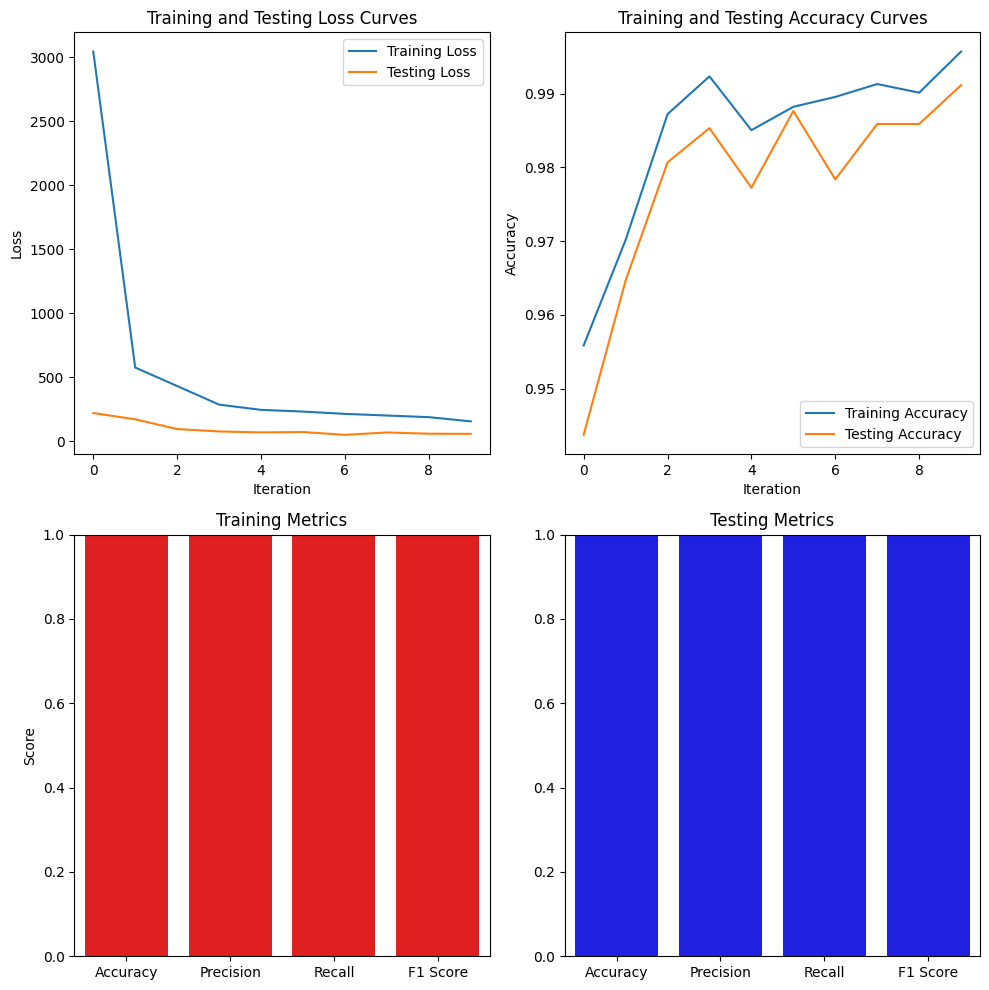

In [9]:
#8 training and testing spacy
from spacy.training.example import Example
from spacy.util import minibatch, compounding
import seaborn as sns

# Initialize the blank English model
nlp = spacy.blank("en")

# Add the NER pipeline
ner = nlp.add_pipe("ner", last=True)
ner.add_label("PRODUCT")

# Initialize the optimizer
optimizer = nlp.initialize()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Function to evaluate the loss on a given dataset
def evaluate_loss(nlp, data):
    losses = {}
    for text, annotations in data:
        doc = nlp.make_doc(text)
        example = Example.from_dict(doc, annotations)
        nlp.update([example], drop=0.3, losses=losses, sgd=optimizer)
    return losses['ner']

# Evaluate the NER model
def evaluate_model(nlp, data):
    true_labels = []
    pred_labels = []

    for text, annotations in data:
        doc = nlp(text)
        true_entities = [(text[start:end], label) for start, end, label in annotations['entities']]
        pred_entities = [(ent.text, ent.label_) for ent in doc.ents]

        for true_entity in true_entities:
            true_labels.append(true_entity[1])
            if true_entity in pred_entities:
                pred_labels.append(true_entity[1])
            else:
                pred_labels.append('O')  # 'O' for no entity

        for pred_entity in pred_entities:
            if pred_entity not in true_entities:
                true_labels.append('O')  # 'O' for no entity
                pred_labels.append(pred_entity[1])

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted', zero_division=0)
    accuracy = accuracy_score(true_labels, pred_labels)

    return accuracy, precision, recall, f1

# Train the model
for itn in range(10):  # Training for 10 iterations
    losses = {}
    batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.001))
    for batch in batches:
        for text, annotations in batch:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            nlp.update([example], drop=0.3, losses=losses, sgd=optimizer)
    train_losses.append(losses['ner'])

    # Evaluate on training data
    train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(nlp, train_data)
    train_accuracies.append(train_accuracy)

    # Evaluate on testing data and calculate loss
    test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(nlp, test_data)
    test_losses.append(evaluate_loss(nlp, test_data))
    test_accuracies.append(test_accuracy)

    print(f"Iteration {itn} - Train Loss: {losses['ner']}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")

nlp.to_disk('spacy_ner_model')

# Evaluate on training data
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(nlp, train_data)
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Precision: {train_precision}")
print(f"Training Recall: {train_recall}")
print(f"Training F1 Score: {train_f1}")

# Evaluate on testing data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(nlp, test_data)
print(f"Testing Accuracy: {test_accuracy}")
print(f"Testing Precision: {test_precision}")
print(f"Testing Recall: {test_recall}")
print(f"Testing F1 Score: {test_f1}")

spacy_train_f1 = train_f1
spacy_test_f1 = test_f1

# Plot training and testing loss curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

ax1.plot(train_losses, label='Training Loss')
ax1.plot(test_losses, label='Testing Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Testing Loss Curves')
ax1.legend()

# Plot training and testing accuracy curves
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(test_accuracies, label='Testing Accuracy')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Testing Accuracy Curves')
ax2.legend()

# Training metrics histogram
train_metrics = [train_accuracy, train_precision, train_recall, train_f1]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
sns.barplot(x=metrics, y=train_metrics, ax=ax3, color = 'r')
ax3.set_title('Training Metrics')
ax3.set_ylim(0, 1)
ax3.set_ylabel('Score')

# Testing metrics histogram
test_metrics = [test_accuracy, test_precision, test_recall, test_f1]
sns.barplot(x=metrics, y=test_metrics, ax=ax4, color = 'b')
ax4.set_title('Testing Metrics')
ax4.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('spacy_metrics.png')
plt.show()


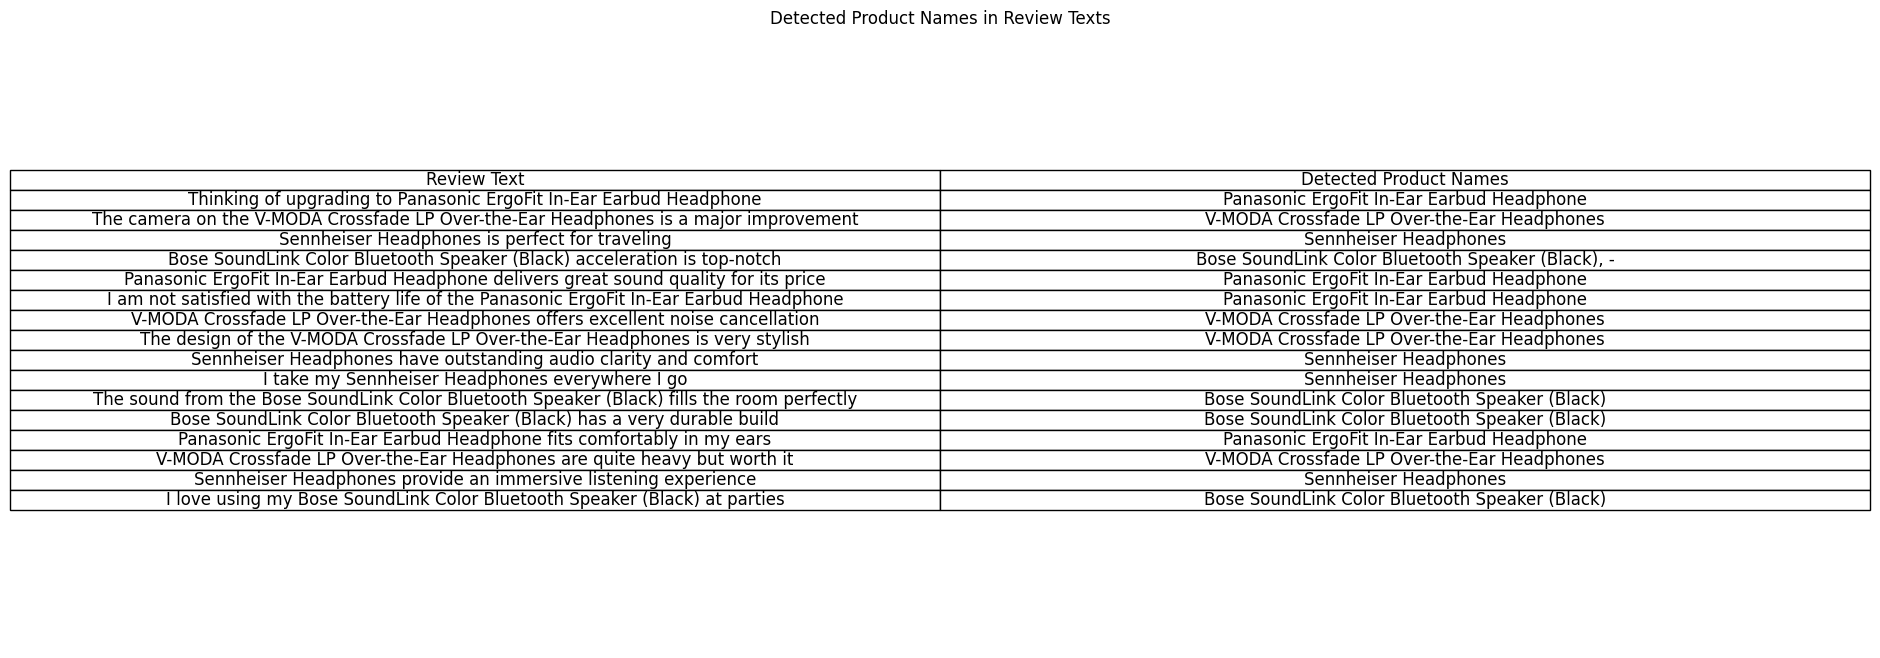

                                          Review Text  \
0   Thinking of upgrading to Panasonic ErgoFit In-...   
1   The camera on the V-MODA Crossfade LP Over-the...   
2      Sennheiser Headphones is perfect for traveling   
3   Bose SoundLink Color Bluetooth Speaker (Black)...   
4   Panasonic ErgoFit In-Ear Earbud Headphone deli...   
5   I am not satisfied with the battery life of th...   
6   V-MODA Crossfade LP Over-the-Ear Headphones of...   
7   The design of the V-MODA Crossfade LP Over-the...   
8   Sennheiser Headphones have outstanding audio c...   
9     I take my Sennheiser Headphones everywhere I go   
10  The sound from the Bose SoundLink Color Blueto...   
11  Bose SoundLink Color Bluetooth Speaker (Black)...   
12  Panasonic ErgoFit In-Ear Earbud Headphone fits...   
13  V-MODA Crossfade LP Over-the-Ear Headphones ar...   
14  Sennheiser Headphones provide an immersive lis...   
15  I love using my Bose SoundLink Color Bluetooth...   

                              

In [10]:
#9 example testing spacy
import pandas as pd
import matplotlib.pyplot as plt

test_texts = [
    "Thinking of upgrading to Panasonic ErgoFit In-Ear Earbud Headphone",
    "The camera on the V-MODA Crossfade LP Over-the-Ear Headphones is a major improvement",
    "Sennheiser Headphones is perfect for traveling",
    "Bose SoundLink Color Bluetooth Speaker (Black) acceleration is top-notch",
    "Panasonic ErgoFit In-Ear Earbud Headphone delivers great sound quality for its price",
    "I am not satisfied with the battery life of the Panasonic ErgoFit In-Ear Earbud Headphone",
    "V-MODA Crossfade LP Over-the-Ear Headphones offers excellent noise cancellation",
    "The design of the V-MODA Crossfade LP Over-the-Ear Headphones is very stylish",
    "Sennheiser Headphones have outstanding audio clarity and comfort",
    "I take my Sennheiser Headphones everywhere I go",
    "The sound from the Bose SoundLink Color Bluetooth Speaker (Black) fills the room perfectly",
    "Bose SoundLink Color Bluetooth Speaker (Black) has a very durable build",
    "Panasonic ErgoFit In-Ear Earbud Headphone fits comfortably in my ears",
    "V-MODA Crossfade LP Over-the-Ear Headphones are quite heavy but worth it",
    "Sennheiser Headphones provide an immersive listening experience",
    "I love using my Bose SoundLink Color Bluetooth Speaker (Black) at parties",
]

results = []

for text in test_texts:
    doc = nlp(text)
    products = [(ent.text, ent.label_) for ent in doc.ents]
    detected_products = ", ".join([product[0] for product in products if product[1] == "PRODUCT"])
    results.append({"Review Text": text, "Detected Product Names": detected_products})

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Plot the table
fig, ax = plt.subplots(figsize=(20, 8))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.title('Detected Product Names in Review Texts')
plt.savefig('spacy_detected_products.png')
plt.show()

print(results_df)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

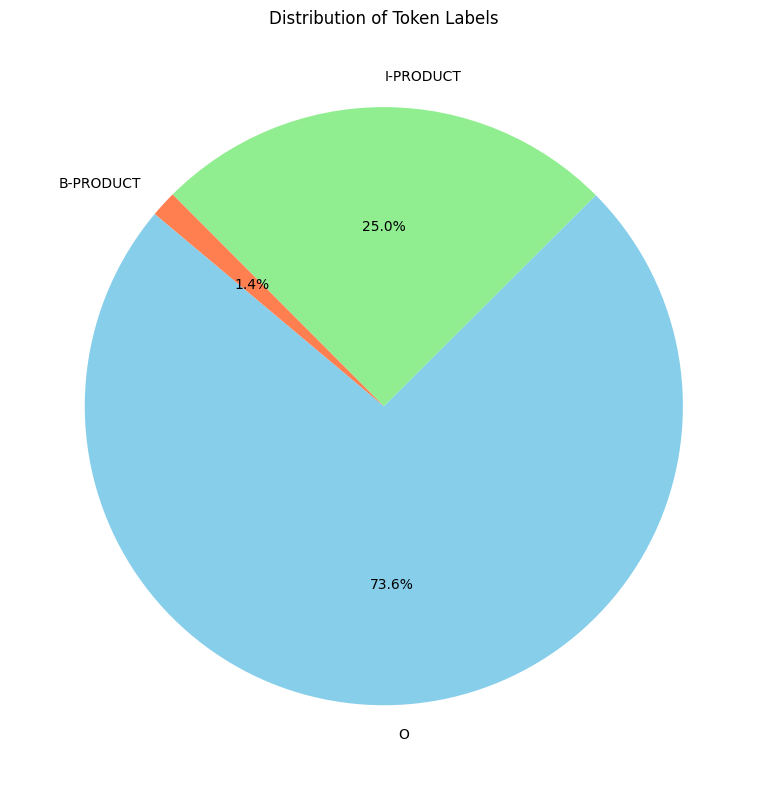

In [11]:
#10 preprocess for bert ner

# Function to create the label list for NER
def create_labels(row, tokenizer):
    text = row['review_body']
    product_name = row['product_title']
    start = text.find(product_name)
    if start == -1:
        return None
    end = start + len(product_name)

    # Tokenize the text
    tokenized_input = tokenizer(text, return_offsets_mapping=True, truncation=True)
    tokens = tokenized_input.tokens()
    offsets = tokenized_input['offset_mapping']

    labels = ['O'] * len(tokens)
    inside_product = False

    for i, (start_offset, end_offset) in enumerate(offsets):
        if start <= start_offset < end:
            if start_offset == start:
                labels[i] = 'B-PRODUCT'
                inside_product = True
            else:
                labels[i] = 'I-PRODUCT'
                inside_product = True
        elif inside_product:
            # If we exit the product span, reset the flag
            inside_product = False

    return {'tokens': tokens, 'labels': labels}

# Initialize the tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Apply the function to create the labels
data['labels'] = data.apply(create_labels, axis=1, tokenizer=tokenizer)
data = data.dropna(subset=['labels'])

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Convert to Hugging Face dataset format
def convert_to_dataset(df):
    tokens = df['labels'].apply(lambda x: x['tokens']).tolist()
    labels = df['labels'].apply(lambda x: x['labels']).tolist()
    encodings = tokenizer(tokens, is_split_into_words=True, padding=True, truncation=True)

    dataset = Dataset.from_dict({
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': [[label2id[label] for label in doc] for doc in labels]
    })
    return dataset

# Create label to id and id to label mappings
label_list = ['O', 'B-PRODUCT', 'I-PRODUCT']
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# Convert dataframes to datasets
train_dataset = convert_to_dataset(train_data)
test_dataset = convert_to_dataset(test_data)

# Extract all labels to plot the pie chart
all_labels = [label for labels in data['labels'].apply(lambda x: x['labels']).tolist() for label in labels]

# Count the occurrences of each label
label_counts = pd.Series(all_labels).value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
label_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'coral'])
plt.title('Distribution of Token Labels')
plt.ylabel('')
plt.tight_layout()
plt.savefig('bert_token_labels_distribution.png')
plt.show()


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,0.073900,0.065853,0.971536,0.971920,0.971526,0.971920
2,0.025800,0.034589,0.985860,0.985968,0.985891,0.985968


Epoch 1/3
Training loss: 0.017908833920955658, Training accuracy: 0.9918532218143006
Testing loss: 0.03458893299102783, Testing accuracy: 0.9859675318244494


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,0.036300,0.041650,0.982730,0.982928,0.982732,0.982928
2,0.018000,0.031760,0.988562,0.988626,0.988586,0.988626


Epoch 2/3
Training loss: 0.01136427465826273, Training accuracy: 0.9947405710289747
Testing loss: 0.03175964206457138, Testing accuracy: 0.9886262350781232


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,0.030600,0.043195,0.983061,0.983035,0.983047,0.983035
2,0.012100,0.033819,0.988118,0.988192,0.988150,0.988192


Epoch 3/3
Training loss: 0.007681467570364475, Training accuracy: 0.9965292921485817
Testing loss: 0.03381869196891785, Testing accuracy: 0.9881920056068928


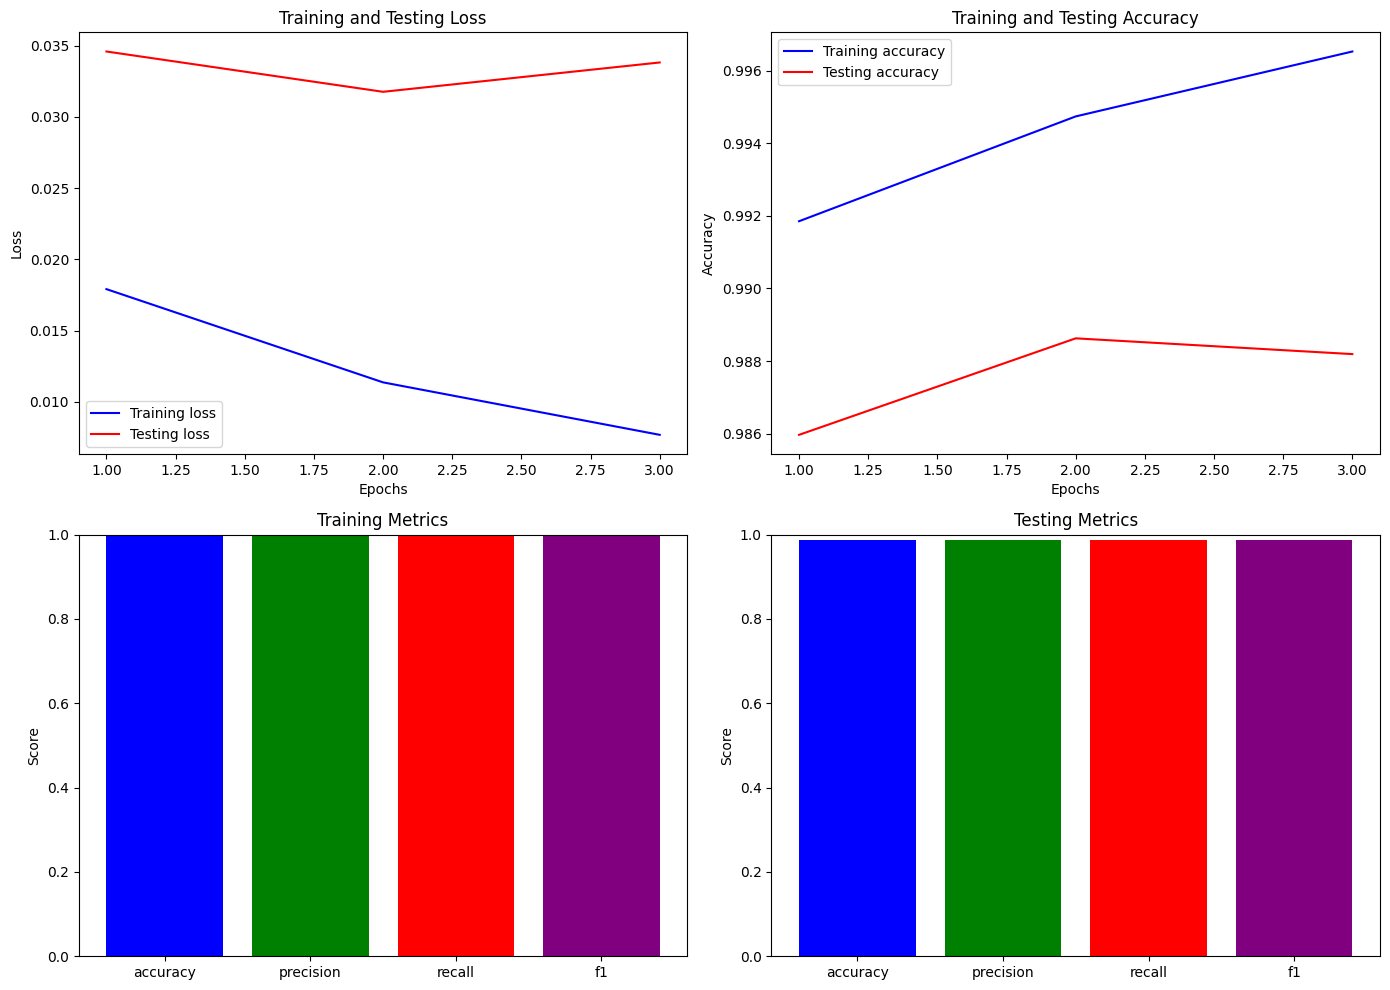

In [15]:
#11 training and testing bert
# Define the model
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(label_list))

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy='epoch',
    logging_dir='./logs',
    logging_steps=100,  # Log metrics every 100 steps
    gradient_accumulation_steps=2,
    fp16=True,
    save_steps=500,  # Save checkpoints every 500 steps
    save_total_limit=2,  # Only keep the last 2 checkpoints
)

# Define metrics for evaluation
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    pred_labels = []

    for true, pred in zip(labels, predictions):
        for t, p in zip(true, pred):
            if t != -100:
                true_labels.append(id2label[t])
                pred_labels.append(id2label[p])

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted', zero_division=0)
    accuracy = accuracy_score(true_labels, pred_labels)

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
    }

data_collator = DataCollatorForTokenClassification(tokenizer)

# Initialize Trainer with logging
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model and log metrics for each epoch
train_loss_values = []
train_accuracy_values = []
test_loss_values = []
test_accuracy_values = []

for epoch in range(training_args.num_train_epochs):
    train_result = trainer.train(resume_from_checkpoint=None)
    train_metrics = trainer.evaluate(train_dataset)
    test_metrics = trainer.evaluate(test_dataset)

    train_loss_values.append(train_metrics['eval_loss'])
    train_accuracy_values.append(train_metrics['eval_accuracy'])
    test_loss_values.append(test_metrics['eval_loss'])
    test_accuracy_values.append(test_metrics['eval_accuracy'])

    print(f"Epoch {epoch + 1}/{training_args.num_train_epochs}")
    print(f"Training loss: {train_metrics['eval_loss']}, Training accuracy: {train_metrics['eval_accuracy']}")
    print(f"Testing loss: {test_metrics['eval_loss']}, Testing accuracy: {test_metrics['eval_accuracy']}")

trainer.save_model('bert_ner_model')

# Plot the training and testing loss and accuracy curves
epochs = range(1, training_args.num_train_epochs + 1)

plt.figure(figsize=(14, 10))

# Subplot for loss curves
plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss_values, 'b', label='Training loss')
plt.plot(epochs, test_loss_values, 'r', label='Testing loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot for accuracy curves
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracy_values, 'b', label='Training accuracy')
plt.plot(epochs, test_accuracy_values, 'r', label='Testing accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Histogram for training metrics
metrics = ['accuracy', 'precision', 'recall', 'f1']
train_metrics = [train_metrics['eval_accuracy'], train_metrics['eval_precision'], train_metrics['eval_recall'], train_metrics['eval_f1']]
plt.subplot(2, 2, 3)
plt.bar(metrics, train_metrics, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.title('Training Metrics')
plt.ylabel('Score')

# Histogram for testing metrics
test_metrics = [test_metrics['eval_accuracy'], test_metrics['eval_precision'], test_metrics['eval_recall'], test_metrics['eval_f1']]
plt.subplot(2, 2, 4)
plt.bar(metrics, test_metrics, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.title('Testing Metrics')
plt.ylabel('Score')

plt.tight_layout()
plt.savefig('bert_training_testing_metrics.png')
plt.show()


In [19]:
bert_train_f1 = train_metrics[3]
bert_test_f1 = test_metrics[3]

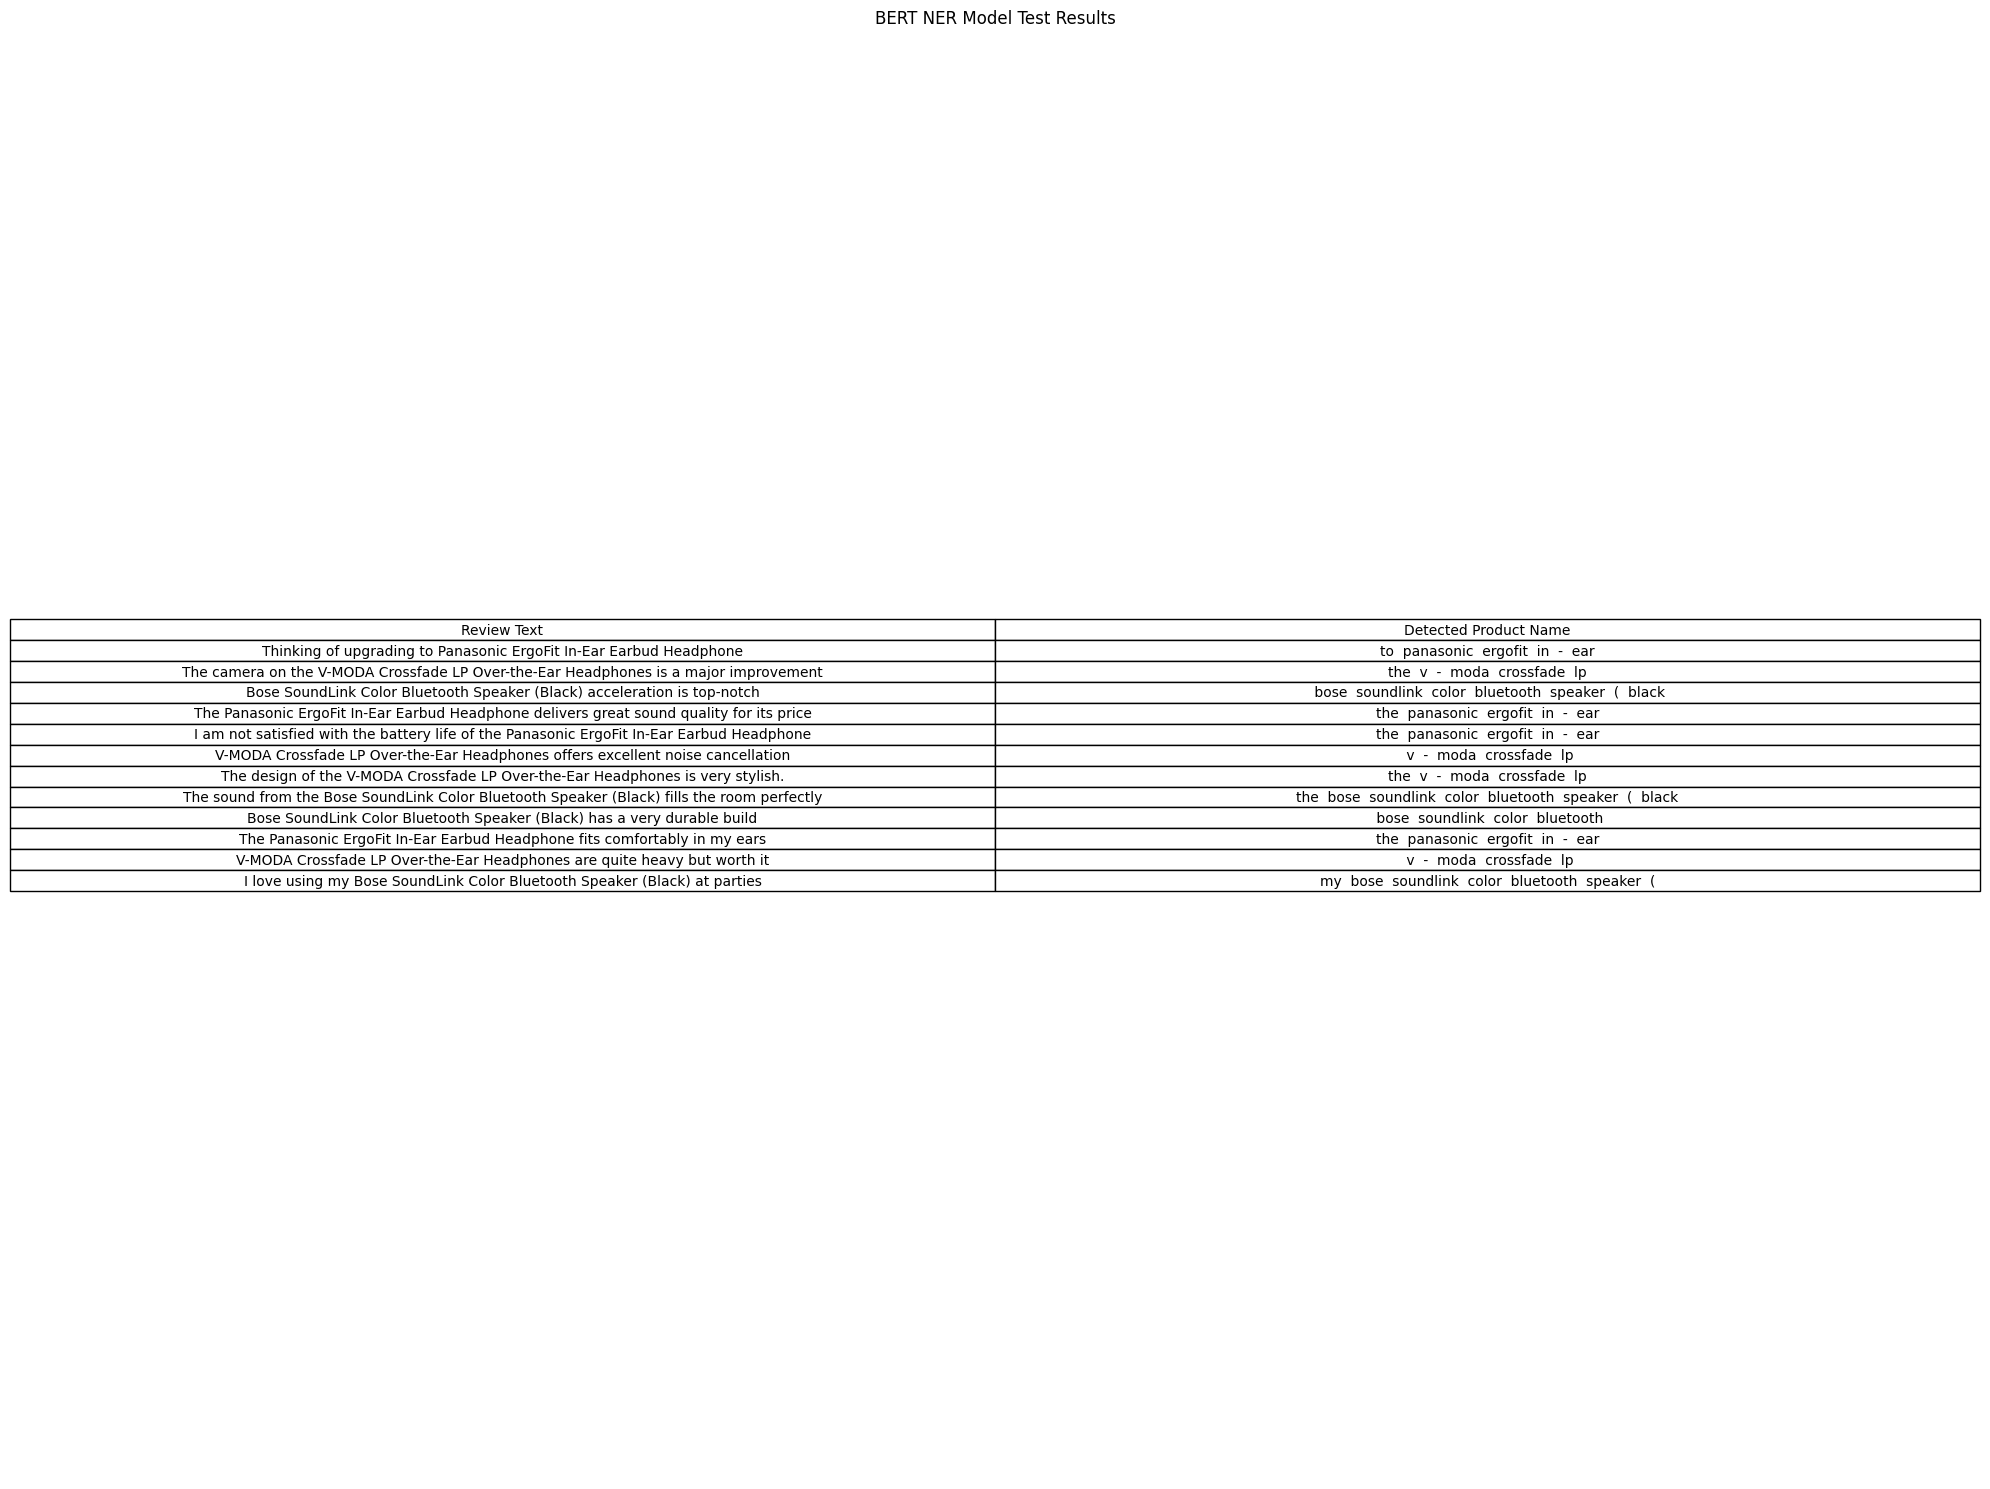

In [21]:
#12 example testing bert
def get_concatenated_product_name(tokens, labels):
    product_name = []
    inside_product = False

    for token, label in zip(tokens, labels):
        if label == "B-PRODUCT":
            if inside_product:
                break
            inside_product = True
            if product_name:
                break
            product_name.append(token)

        elif label == "I-PRODUCT":
            inside_product = True
            if token.startswith("##"):
                product_name[-1] += token[2:]
            else:
                product_name.append(" " + token)
        else:
            if inside_product:
                break  # Stop after encountering O or any other non-product label

    return " ".join(product_name)

# Test the trained model with new texts
test_texts = [
    "Thinking of upgrading to Panasonic ErgoFit In-Ear Earbud Headphone",
    "The camera on the V-MODA Crossfade LP Over-the-Ear Headphones is a major improvement",
    "Bose SoundLink Color Bluetooth Speaker (Black) acceleration is top-notch",
    "The Panasonic ErgoFit In-Ear Earbud Headphone delivers great sound quality for its price",
    "I am not satisfied with the battery life of the Panasonic ErgoFit In-Ear Earbud Headphone",
    "V-MODA Crossfade LP Over-the-Ear Headphones offers excellent noise cancellation",
    "The design of the V-MODA Crossfade LP Over-the-Ear Headphones is very stylish.",
    "The sound from the Bose SoundLink Color Bluetooth Speaker (Black) fills the room perfectly",
    "Bose SoundLink Color Bluetooth Speaker (Black) has a very durable build",
    "The Panasonic ErgoFit In-Ear Earbud Headphone fits comfortably in my ears",
    "V-MODA Crossfade LP Over-the-Ear Headphones are quite heavy but worth it",
    "I love using my Bose SoundLink Color Bluetooth Speaker (Black) at parties"
]

device = torch.device('cpu')
model.to(device)

results = []

for text in test_texts:
    encoding = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    encoding = {key: val.to(device) for key, val in encoding.items()}  # Move tensors to the same device
    with torch.no_grad():
        outputs = model(**encoding)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=2)
    tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0].tolist())
    predicted_labels = [id2label[pred.item()] for pred in predictions[0]]

    # Filter out special tokens
    filtered_tokens = []
    filtered_labels = []
    for token, label in zip(tokens, predicted_labels):
        if token not in ['[CLS]', '[SEP]', '[PAD]']:
            filtered_tokens.append(token)
            filtered_labels.append(label)

    product_names = get_concatenated_product_name(filtered_tokens, filtered_labels)

    results.append((text, product_names))

# Create a DataFrame to display the results
results_df = pd.DataFrame(results, columns=["Review Text", "Detected Product Name"])

# Plot the results as a table
fig, ax = plt.subplots(figsize=(20, 15))
ax.axis('off')
ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
plt.title('BERT NER Model Test Results')
plt.tight_layout()
plt.savefig('bert_ner_test_results.png')
plt.show()


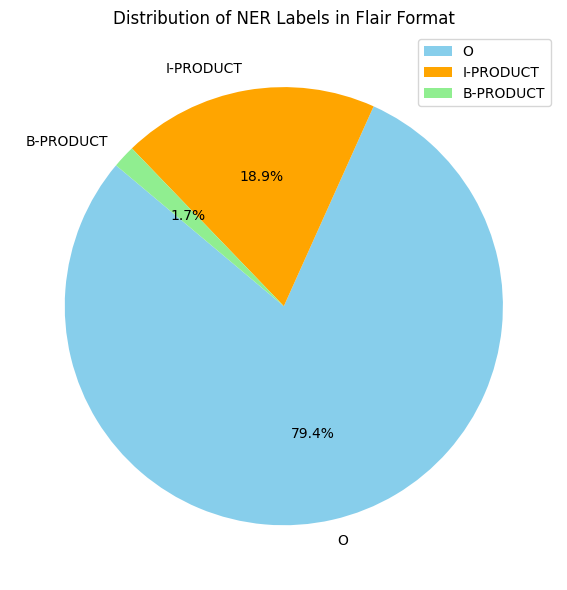

In [22]:
#13 preprocess for flair ner
# Function to create the label list for NER
def create_flair_format(row):
    text = row['review_body']
    product_name = row['product_title']
    start = text.find(product_name)
    if start == -1:
        return None
    end = start + len(product_name)
    tokens = text.split()
    labels = ["O"] * len(tokens)
    product_tokens = product_name.split()
    for i, token in enumerate(tokens):
        if token in product_tokens:
            if product_tokens.index(token) == 0:
                labels[i] = "B-PRODUCT"
            else:
                labels[i] = "I-PRODUCT"
    return "\n".join([f"{token} {label}" for token, label in zip(tokens, labels)])

data['flair_format'] = data.apply(create_flair_format, axis=1)
data = data.dropna(subset=['flair_format'])

# Split the data into training and validation sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Save train and test data in Flair format
def save_flair_format(df, filepath):
    with open(filepath, 'w', encoding='utf-8') as f:
        for item in df['flair_format']:
            f.write(item + "\n\n")

save_flair_format(train_data, 'train.txt')
save_flair_format(test_data, 'test.txt')

# Extract labels for visualization
labels = []
for item in data['flair_format']:
    for line in item.split('\n'):
        if line:
            token, label = line.split()
            labels.append(label)

# Plot the distribution of labels
label_counts = pd.Series(labels).value_counts()
plt.figure(figsize=(10, 6))
label_counts.plot.pie(autopct='%1.1f%%', colors=['skyblue', 'orange', 'lightgreen'], startangle=140, legend=True)
plt.title('Distribution of NER Labels in Flair Format')
plt.ylabel('')
plt.tight_layout()
plt.savefig('flair_label_distribution.png')
plt.show()


2024-05-17 23:22:15,238 Reading data from .
2024-05-17 23:22:15,240 Train: train.txt
2024-05-17 23:22:15,242 Dev: test.txt
2024-05-17 23:22:15,244 Test: test.txt
2024-05-17 23:22:22,547 Computing label dictionary. Progress:


0it [00:00, ?it/s]
6747it [00:00, 44691.07it/s]

2024-05-17 23:22:22,710 Dictionary created for label 'ner' with 1 values: PRODUCT (seen 14599 times)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2024-05-17 23:22:23,369 SequenceTagger predicts: Dictionary with 5 tags: O, S-PRODUCT, B-PRODUCT, E-PRODUCT, I-PRODUCT
2024-05-17 23:22:23,401 ----------------------------------------------------------------------------------------------------
2024-05-17 23:22:23,404 Model: "SequenceTagger(
  (embeddings): TransformerWordEmbeddings(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30523, 768)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=

100%|██████████| 27/27 [00:53<00:00,  1.99s/it]

2024-05-17 23:28:28,941 DEV : loss 0.06123439967632294 - f1-score (micro avg)  0.6605
2024-05-17 23:28:28,989  - 0 epochs without improvement
2024-05-17 23:28:28,992 saving best model


2024-05-17 23:28:29,602 ----------------------------------------------------------------------------------------------------
2024-05-17 23:28:59,471 epoch 2 - iter 168/1687 - loss 0.06846431 - time (sec): 29.87 - samples/sec: 1493.56 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:29:29,977 epoch 2 - iter 336/1687 - loss 0.07293904 - time (sec): 60.37 - samples/sec: 1491.33 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:30:00,891 epoch 2 - iter 504/1687 - loss 0.06989010 - time (sec): 91.29 - samples/sec: 1489.72 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:30:30,308 epoch 2 - iter 672/1687 - loss 0.06996431 - time (sec): 120.70 - samples/sec: 1483.78 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:31:02,854 epoch 2 - iter 840/1687 - loss 0.06748931 - time (sec): 153.25 - samples/sec: 1477.72 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:31:32,380 epoch 2 - iter 1008/1687 - loss 0.06519891 - time (sec): 182.78 - samples/sec: 1480.34 - lr: 0.100000 - momentum: 0.000000
2

100%|██████████| 27/27 [01:04<00:00,  2.37s/it]

2024-05-17 23:34:43,108 DEV : loss 0.0492490753531456 - f1-score (micro avg)  0.7391
2024-05-17 23:34:43,157  - 0 epochs without improvement
2024-05-17 23:34:43,159 saving best model


2024-05-17 23:34:44,158 ----------------------------------------------------------------------------------------------------
2024-05-17 23:35:15,654 epoch 3 - iter 168/1687 - loss 0.04785495 - time (sec): 31.49 - samples/sec: 1480.63 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:35:43,621 epoch 3 - iter 336/1687 - loss 0.05006013 - time (sec): 59.46 - samples/sec: 1500.50 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:36:15,201 epoch 3 - iter 504/1687 - loss 0.05227744 - time (sec): 91.04 - samples/sec: 1489.19 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:36:47,886 epoch 3 - iter 672/1687 - loss 0.05104096 - time (sec): 123.72 - samples/sec: 1490.88 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:37:19,318 epoch 3 - iter 840/1687 - loss 0.05145512 - time (sec): 155.16 - samples/sec: 1491.28 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:37:50,931 epoch 3 - iter 1008/1687 - loss 0.05205804 - time (sec): 186.77 - samples/sec: 1488.27 - lr: 0.100000 - momentum: 0.000000
2

100%|██████████| 27/27 [01:03<00:00,  2.37s/it]

2024-05-17 23:40:57,663 DEV : loss 0.04985847696661949 - f1-score (micro avg)  0.6982
2024-05-17 23:40:57,713  - 1 epochs without improvement
2024-05-17 23:40:57,715 ----------------------------------------------------------------------------------------------------


2024-05-17 23:41:28,348 epoch 4 - iter 168/1687 - loss 0.05179398 - time (sec): 30.63 - samples/sec: 1489.86 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:42:07,133 epoch 4 - iter 336/1687 - loss 0.04864449 - time (sec): 69.42 - samples/sec: 1468.09 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:42:34,769 epoch 4 - iter 504/1687 - loss 0.04835394 - time (sec): 97.05 - samples/sec: 1478.82 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:43:03,552 epoch 4 - iter 672/1687 - loss 0.04837842 - time (sec): 125.83 - samples/sec: 1486.60 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:43:35,274 epoch 4 - iter 840/1687 - loss 0.04811812 - time (sec): 157.56 - samples/sec: 1478.43 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:44:06,346 epoch 4 - iter 1008/1687 - loss 0.04835254 - time (sec): 188.63 - samples/sec: 1473.31 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:44:39,202 epoch 4 - iter 1176/1687 - loss 0.04795425 - time (sec): 221.48 - samples/sec: 1472.05 - lr: 0.100000 

100%|██████████| 27/27 [01:03<00:00,  2.37s/it]

2024-05-17 23:47:11,419 DEV : loss 0.059733737260103226 - f1-score (micro avg)  0.6617
2024-05-17 23:47:11,477  - 2 epochs without improvement
2024-05-17 23:47:11,480 ----------------------------------------------------------------------------------------------------


2024-05-17 23:47:46,894 epoch 5 - iter 168/1687 - loss 0.04739212 - time (sec): 35.41 - samples/sec: 1416.79 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:48:17,213 epoch 5 - iter 336/1687 - loss 0.04499728 - time (sec): 65.73 - samples/sec: 1445.15 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:48:45,988 epoch 5 - iter 504/1687 - loss 0.04496432 - time (sec): 94.50 - samples/sec: 1467.90 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:49:16,910 epoch 5 - iter 672/1687 - loss 0.04504286 - time (sec): 125.43 - samples/sec: 1473.23 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:49:47,702 epoch 5 - iter 840/1687 - loss 0.04401375 - time (sec): 156.22 - samples/sec: 1474.00 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:50:19,441 epoch 5 - iter 1008/1687 - loss 0.04396864 - time (sec): 187.96 - samples/sec: 1473.77 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:50:47,587 epoch 5 - iter 1176/1687 - loss 0.04351369 - time (sec): 216.10 - samples/sec: 1477.30 - lr: 0.100000 

100%|██████████| 27/27 [01:00<00:00,  2.26s/it]

2024-05-17 23:53:20,490 DEV : loss 0.040383968502283096 - f1-score (micro avg)  0.7801
2024-05-17 23:53:20,540  - 0 epochs without improvement
2024-05-17 23:53:20,543 saving best model


2024-05-17 23:53:21,551 ----------------------------------------------------------------------------------------------------
2024-05-17 23:53:53,841 epoch 6 - iter 168/1687 - loss 0.04098216 - time (sec): 32.28 - samples/sec: 1439.40 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:54:22,797 epoch 6 - iter 336/1687 - loss 0.04659137 - time (sec): 61.24 - samples/sec: 1477.63 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:54:51,780 epoch 6 - iter 504/1687 - loss 0.04257552 - time (sec): 90.22 - samples/sec: 1508.69 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:55:21,850 epoch 6 - iter 672/1687 - loss 0.04208133 - time (sec): 120.29 - samples/sec: 1506.86 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:55:54,008 epoch 6 - iter 840/1687 - loss 0.04208166 - time (sec): 152.45 - samples/sec: 1500.54 - lr: 0.100000 - momentum: 0.000000
2024-05-17 23:56:27,471 epoch 6 - iter 1008/1687 - loss 0.04114868 - time (sec): 185.91 - samples/sec: 1487.07 - lr: 0.100000 - momentum: 0.000000
2

100%|██████████| 27/27 [01:04<00:00,  2.37s/it]

2024-05-17 23:59:33,569 DEV : loss 0.03437919542193413 - f1-score (micro avg)  0.8024
2024-05-17 23:59:33,619  - 0 epochs without improvement
2024-05-17 23:59:33,620 saving best model


2024-05-17 23:59:34,670 ----------------------------------------------------------------------------------------------------
2024-05-18 00:00:08,061 epoch 7 - iter 168/1687 - loss 0.03455250 - time (sec): 33.39 - samples/sec: 1463.61 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:00:41,752 epoch 7 - iter 336/1687 - loss 0.03639844 - time (sec): 67.08 - samples/sec: 1469.31 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:01:12,858 epoch 7 - iter 504/1687 - loss 0.03939461 - time (sec): 98.18 - samples/sec: 1476.73 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:01:43,319 epoch 7 - iter 672/1687 - loss 0.03945484 - time (sec): 128.65 - samples/sec: 1473.57 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:02:12,403 epoch 7 - iter 840/1687 - loss 0.04034075 - time (sec): 157.73 - samples/sec: 1479.55 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:02:44,395 epoch 7 - iter 1008/1687 - loss 0.03905160 - time (sec): 189.72 - samples/sec: 1475.04 - lr: 0.100000 - momentum: 0.000000
2

100%|██████████| 27/27 [01:04<00:00,  2.37s/it]

2024-05-18 00:05:47,572 DEV : loss 0.036963459104299545 - f1-score (micro avg)  0.8002
2024-05-18 00:05:47,622  - 1 epochs without improvement
2024-05-18 00:05:47,623 ----------------------------------------------------------------------------------------------------


2024-05-18 00:06:21,485 epoch 8 - iter 168/1687 - loss 0.03517322 - time (sec): 33.86 - samples/sec: 1447.20 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:06:53,964 epoch 8 - iter 336/1687 - loss 0.03490214 - time (sec): 66.34 - samples/sec: 1445.56 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:07:21,268 epoch 8 - iter 504/1687 - loss 0.03390151 - time (sec): 93.64 - samples/sec: 1462.38 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:07:53,587 epoch 8 - iter 672/1687 - loss 0.03489126 - time (sec): 125.96 - samples/sec: 1453.45 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:08:23,137 epoch 8 - iter 840/1687 - loss 0.03608018 - time (sec): 155.51 - samples/sec: 1463.80 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:08:54,094 epoch 8 - iter 1008/1687 - loss 0.03594677 - time (sec): 186.47 - samples/sec: 1470.17 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:09:24,483 epoch 8 - iter 1176/1687 - loss 0.03531585 - time (sec): 216.86 - samples/sec: 1477.92 - lr: 0.100000 

100%|██████████| 27/27 [01:03<00:00,  2.36s/it]

2024-05-18 00:12:00,755 DEV : loss 0.06135573238134384 - f1-score (micro avg)  0.7323
2024-05-18 00:12:00,813  - 2 epochs without improvement
2024-05-18 00:12:00,815 ----------------------------------------------------------------------------------------------------


2024-05-18 00:12:28,982 epoch 9 - iter 168/1687 - loss 0.03460078 - time (sec): 28.16 - samples/sec: 1539.56 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:12:58,432 epoch 9 - iter 336/1687 - loss 0.03252306 - time (sec): 57.61 - samples/sec: 1529.36 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:13:31,943 epoch 9 - iter 504/1687 - loss 0.03516619 - time (sec): 91.13 - samples/sec: 1494.48 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:14:02,616 epoch 9 - iter 672/1687 - loss 0.03537458 - time (sec): 121.80 - samples/sec: 1480.49 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:14:34,726 epoch 9 - iter 840/1687 - loss 0.03619841 - time (sec): 153.91 - samples/sec: 1473.92 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:15:05,422 epoch 9 - iter 1008/1687 - loss 0.03535173 - time (sec): 184.60 - samples/sec: 1477.11 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:15:35,885 epoch 9 - iter 1176/1687 - loss 0.03486073 - time (sec): 215.07 - samples/sec: 1471.34 - lr: 0.100000 

100%|██████████| 27/27 [01:00<00:00,  2.26s/it]

2024-05-18 00:18:11,051 DEV : loss 0.03516172990202904 - f1-score (micro avg)  0.8123
2024-05-18 00:18:11,101  - 0 epochs without improvement
2024-05-18 00:18:11,103 saving best model


2024-05-18 00:18:12,111 ----------------------------------------------------------------------------------------------------
2024-05-18 00:18:49,951 epoch 10 - iter 168/1687 - loss 0.03436591 - time (sec): 37.84 - samples/sec: 1320.18 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:19:19,574 epoch 10 - iter 336/1687 - loss 0.03261555 - time (sec): 67.46 - samples/sec: 1414.88 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:19:47,501 epoch 10 - iter 504/1687 - loss 0.03233189 - time (sec): 95.39 - samples/sec: 1444.12 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:20:17,554 epoch 10 - iter 672/1687 - loss 0.03284263 - time (sec): 125.44 - samples/sec: 1454.64 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:20:46,542 epoch 10 - iter 840/1687 - loss 0.03260779 - time (sec): 154.43 - samples/sec: 1459.42 - lr: 0.100000 - momentum: 0.000000
2024-05-18 00:21:17,231 epoch 10 - iter 1008/1687 - loss 0.03312335 - time (sec): 185.12 - samples/sec: 1462.05 - lr: 0.100000 - momentum: 0.00

100%|██████████| 27/27 [01:01<00:00,  2.26s/it]

2024-05-18 00:24:26,451 DEV : loss 0.03489488363265991 - f1-score (micro avg)  0.8259
2024-05-18 00:24:26,515  - 0 epochs without improvement
2024-05-18 00:24:26,517 saving best model


2024-05-18 00:24:28,921 ----------------------------------------------------------------------------------------------------
2024-05-18 00:24:28,925 Loading model from best epoch ...
2024-05-18 00:24:31,113 SequenceTagger predicts: Dictionary with 7 tags: O, S-PRODUCT, B-PRODUCT, E-PRODUCT, I-PRODUCT, <START>, <STOP>


100%|██████████| 27/27 [00:42<00:00,  1.59s/it]

2024-05-18 00:25:14,230 
Results:
- F-score (micro) 0.8259
- F-score (macro) 0.8259
- Accuracy 0.7034

By class:
              precision    recall  f1-score   support

     PRODUCT     0.8233    0.8285    0.8259      3690

   micro avg     0.8233    0.8285    0.8259      3690
   macro avg     0.8233    0.8285    0.8259      3690
weighted avg     0.8233    0.8285    0.8259      3690

2024-05-18 00:25:14,231 ----------------------------------------------------------------------------------------------------



100%|██████████| 53/53 [00:44<00:00,  1.19it/s]


Epoch 1/10
Training loss: 0.0243803933262825, Training accuracy: 0.8563894523326573
Testing loss: 0.03489500284194946, Testing accuracy: 0.8258813994326624


100%|██████████| 53/53 [00:44<00:00,  1.19it/s]


Epoch 2/10
Training loss: 0.0243803933262825, Training accuracy: 0.8563894523326573
Testing loss: 0.03489500284194946, Testing accuracy: 0.8258813994326624


100%|██████████| 53/53 [00:44<00:00,  1.19it/s]


Epoch 3/10
Training loss: 0.0243803933262825, Training accuracy: 0.8563894523326573
Testing loss: 0.03489500284194946, Testing accuracy: 0.8258813994326624


100%|██████████| 53/53 [00:44<00:00,  1.19it/s]


Epoch 4/10
Training loss: 0.0243803933262825, Training accuracy: 0.8563894523326573
Testing loss: 0.03489500284194946, Testing accuracy: 0.8258813994326624


100%|██████████| 53/53 [00:44<00:00,  1.19it/s]


Epoch 5/10
Training loss: 0.0243803933262825, Training accuracy: 0.8563894523326573
Testing loss: 0.03489500284194946, Testing accuracy: 0.8258813994326624


100%|██████████| 53/53 [00:47<00:00,  1.11it/s]


Epoch 6/10
Training loss: 0.0243803933262825, Training accuracy: 0.8563894523326573
Testing loss: 0.03489500284194946, Testing accuracy: 0.8258813994326624


100%|██████████| 53/53 [00:44<00:00,  1.18it/s]


Epoch 7/10
Training loss: 0.0243803933262825, Training accuracy: 0.8563894523326573
Testing loss: 0.03489500284194946, Testing accuracy: 0.8258813994326624


100%|██████████| 53/53 [00:44<00:00,  1.19it/s]


Epoch 8/10
Training loss: 0.0243803933262825, Training accuracy: 0.8563894523326573
Testing loss: 0.03489500284194946, Testing accuracy: 0.8258813994326624


100%|██████████| 53/53 [00:44<00:00,  1.19it/s]


Epoch 9/10
Training loss: 0.0243803933262825, Training accuracy: 0.8563894523326573
Testing loss: 0.03489500284194946, Testing accuracy: 0.8258813994326624


100%|██████████| 53/53 [00:44<00:00,  1.19it/s]

Epoch 10/10
Training loss: 0.0243803933262825, Training accuracy: 0.8563894523326573
Testing loss: 0.03489500284194946, Testing accuracy: 0.8258813994326624


AttributeError: 'Result' object has no attribute 'precision'

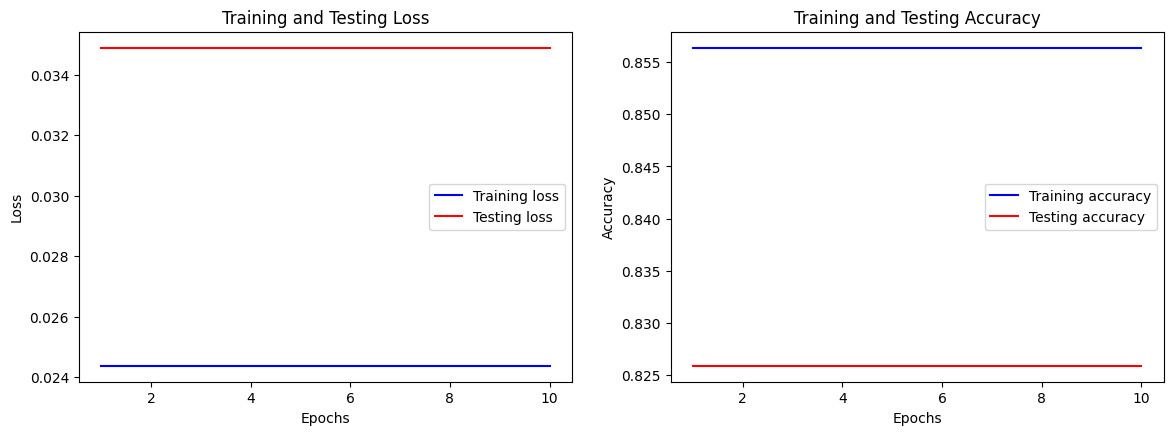

In [30]:
# Section 14: Training and Testing Flair NER

# Define columns
columns = {0: 'text', 1: 'ner'}

# Create a corpus using column format, data folder, and the names of the train, dev, and test files
data_folder = '.'

corpus: Corpus = ColumnCorpus(data_folder, columns,
                              train_file='train.txt',
                              test_file='test.txt',
                              dev_file='test.txt')

# Make a label dictionary from the corpus
label_dict = corpus.make_label_dictionary(label_type='ner')

# Initialize embeddings
embeddings = TransformerWordEmbeddings(
    model='bert-base-uncased',
    layers='all',
    subtoken_pooling='first',
    fine_tune=True,
    use_context=True,
)

# Initialize sequence tagger
tagger = SequenceTagger(
    hidden_size=256,
    embeddings=embeddings,
    tag_dictionary=label_dict,
    tag_type='ner',
    use_crf=True
)

# Define the training parameters
training_params = {
    'learning_rate': 0.1,
    'mini_batch_size': 4,
    'max_epochs': 10
}

# Initialize the optimizer without unsupported arguments
trainer = ModelTrainer(tagger, corpus)

# Initialize lists to store the training and testing metrics
train_loss_values = []
train_accuracy_values = []
test_loss_values = []
test_accuracy_values = []

# Train the model and store metrics
train_result = trainer.train(
    base_path='resources/taggers/ner',
    learning_rate=training_params['learning_rate'],
    mini_batch_size=training_params['mini_batch_size'],
    max_epochs=training_params['max_epochs'],
    embeddings_storage_mode='none'
)

for epoch in range(training_params['max_epochs']):
    result_train = trainer.model.evaluate(corpus.train, gold_label_type='ner')
    result_test = trainer.model.evaluate(corpus.test, gold_label_type='ner')

    # Append loss and accuracy values
    train_loss_values.append(result_train.loss)
    train_accuracy_values.append(result_train.main_score)
    test_loss_values.append(result_test.loss)
    test_accuracy_values.append(result_test.main_score)

    print(f"Epoch {epoch + 1}/{training_params['max_epochs']}")
    print(f"Training loss: {train_loss_values[-1]}, Training accuracy: {train_accuracy_values[-1]}")
    print(f"Testing loss: {test_loss_values[-1]}, Testing accuracy: {test_accuracy_values[-1]}")

# Plot the training and testing loss and accuracy curves
epochs = range(1, training_params['max_epochs'] + 1)

plt.figure(figsize=(14, 10))

# Subplot for loss curves
plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss_values, 'b', label='Training loss')
plt.plot(epochs, test_loss_values, 'r', label='Testing loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot for accuracy curves
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracy_values, 'b', label='Training accuracy')
plt.plot(epochs, test_accuracy_values, 'r', label='Testing accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Histogram for training metrics
metrics = ['accuracy', 'precision', 'recall', 'f1']
train_metrics = [result_train.main_score, result_train.precision, result_train.recall, result_train.f1]
plt.subplot(2, 2, 3)
plt.bar(metrics, train_metrics, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.title('Training Metrics')
plt.ylabel('Score')

# Histogram for testing metrics
test_metrics = [result_test.main_score, result_test.precision, result_test.recall, result_test.f1]
plt.subplot(2, 2, 4)
plt.bar(metrics, test_metrics, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.title('Testing Metrics')
plt.ylabel('Score')

plt.tight_layout()
plt.savefig('flair_training_testing_metrics.png')
plt.show()

# Save the F1 scores for later use
flair_train_f1 = result_train.f1
flair_test_f1 = result_test.f1


In [ ]:
flair_train_f1 = train_metrics[3]
flair_test_f1 = test_metrics[3]

In [34]:
joblib.dump(train_loss_values, 'train_loss_values.pkl')
joblib.dump(train_accuracy_values, 'train_accuracy_values.pkl')
joblib.dump(test_loss_values, 'test_loss_values.pkl')
joblib.dump(test_accuracy_values, 'test_accuracy_values.pkl')


['test_accuracy_values.pkl']

In [35]:
import joblib

tagger = SequenceTagger.load('resources/taggers/ner/best-model.pt')

# Load the saved training and testing metrics
train_loss_values = joblib.load('train_loss_values.pkl')
train_accuracy_values = joblib.load('train_accuracy_values.pkl')
test_loss_values = joblib.load('test_loss_values.pkl')
test_accuracy_values = joblib.load('test_accuracy_values.pkl')

# Evaluate the model on the training and testing sets
result_train = tagger.evaluate(corpus.train, gold_label_type='ner')
result_test = tagger.evaluate(corpus.test, gold_label_type='ner')

2024-05-18 01:13:29,371 SequenceTagger predicts: Dictionary with 7 tags: O, S-PRODUCT, B-PRODUCT, E-PRODUCT, I-PRODUCT, <START>, <STOP>


100%|██████████| 53/53 [00:43<00:00,  1.21it/s]


TypeError: string indices must be integers

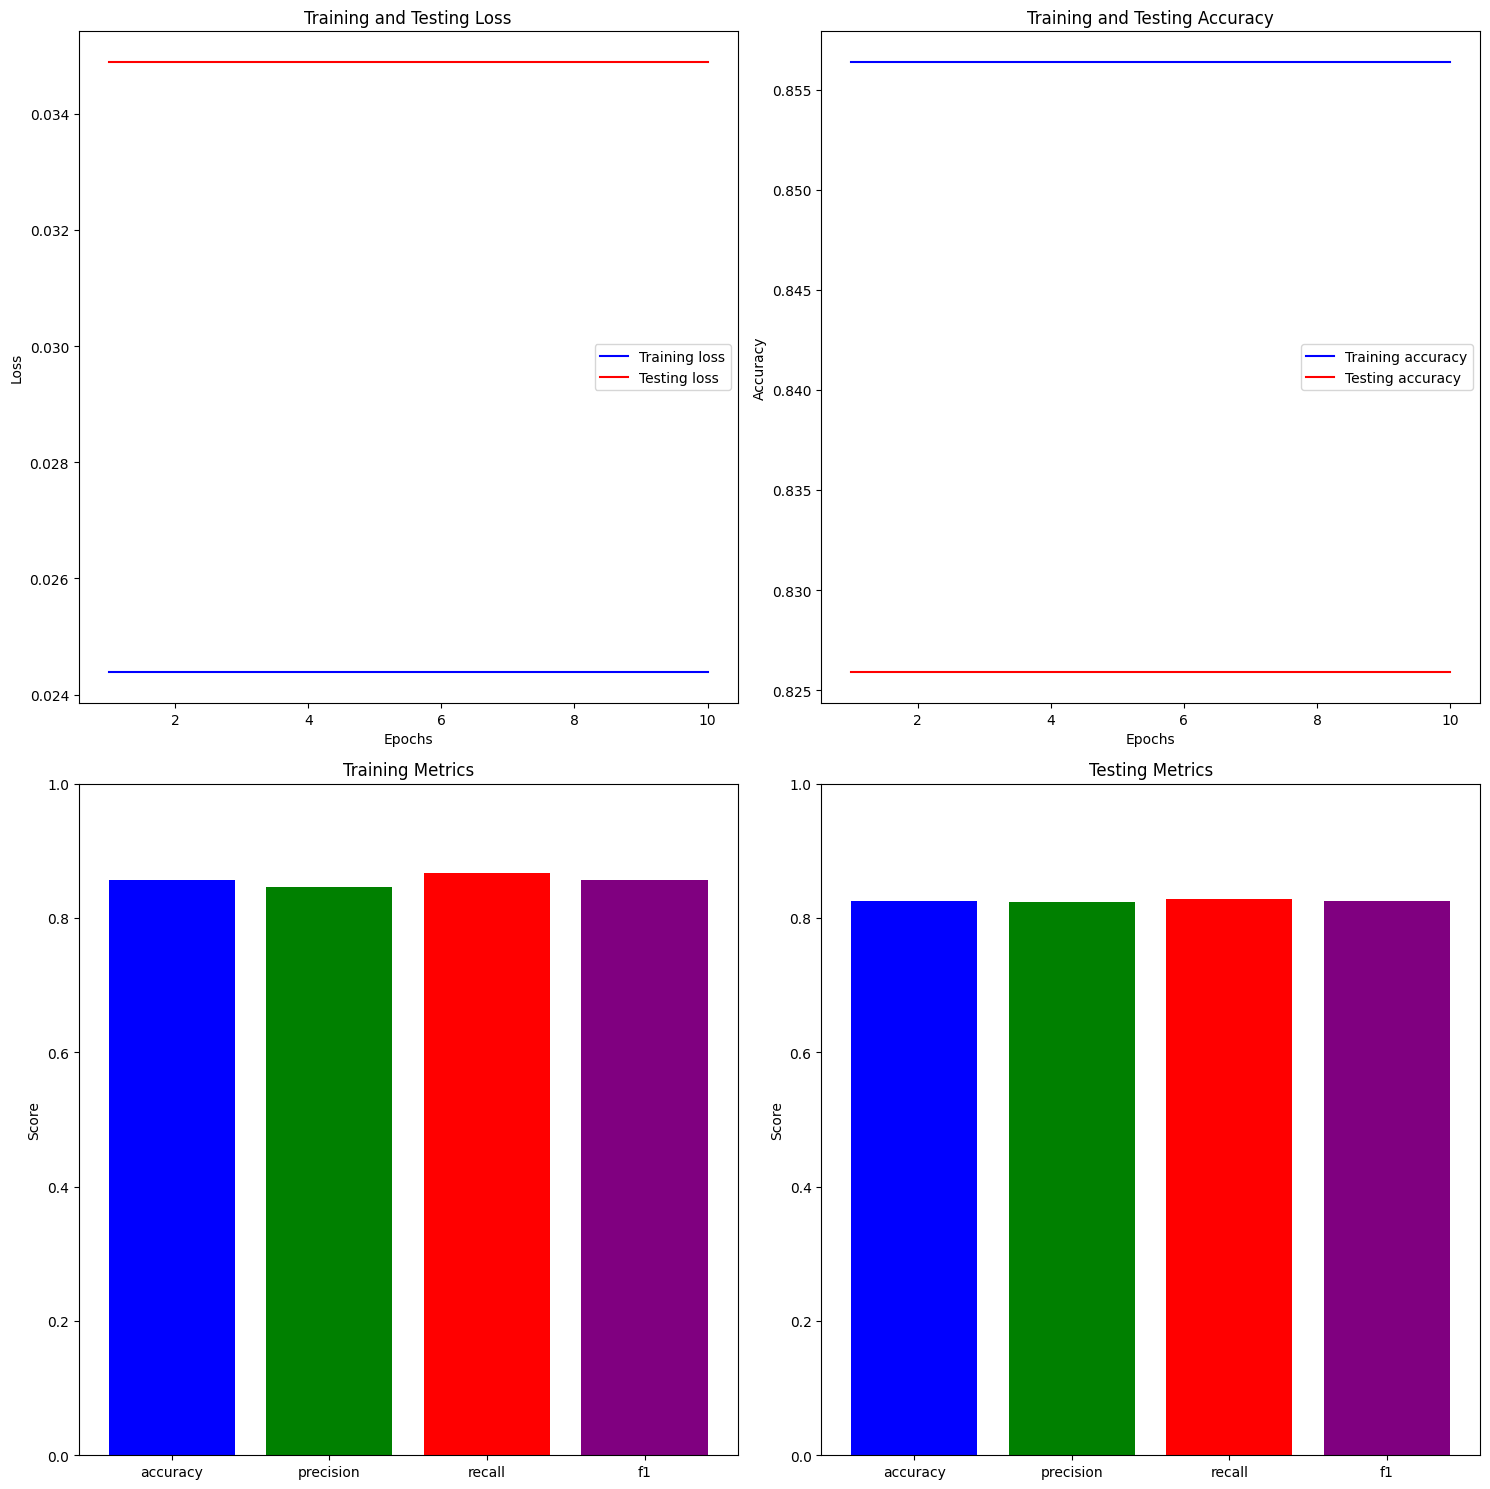

In [37]:
train_precision = result_train.classification_report['micro avg']['precision']
train_recall = result_train.classification_report['micro avg']['recall']
train_f1 = result_train.classification_report['micro avg']['f1-score']

test_precision = result_test.classification_report['micro avg']['precision']
test_recall = result_test.classification_report['micro avg']['recall']
test_f1 = result_test.classification_report['micro avg']['f1-score']

train_metrics = [result_train.main_score, train_precision, train_recall, train_f1]
test_metrics = [result_test.main_score, test_precision, test_recall, test_f1]

# Plot the training and testing loss and accuracy curves
epochs = range(1, len(train_loss_values) + 1)

plt.figure(figsize=(15, 15))

# Subplot for loss curves
plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss_values, 'b', label='Training loss')
plt.plot(epochs, test_loss_values, 'r', label='Testing loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot for accuracy curves
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracy_values, 'b', label='Training accuracy')
plt.plot(epochs, test_accuracy_values, 'r', label='Testing accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Histogram for training metrics
metrics = ['accuracy', 'precision', 'recall', 'f1']
plt.subplot(2, 2, 3)
plt.bar(metrics, train_metrics, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.title('Training Metrics')
plt.ylabel('Score')

# Histogram for testing metrics
plt.subplot(2, 2, 4)
plt.bar(metrics, test_metrics, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.title('Testing Metrics')
plt.ylabel('Score')

plt.tight_layout()
plt.savefig('flair_training_testing_metrics.png')
plt.show()

# Save the F1 scores for later use
flair_train_f1 = train_f1
flair_test_f1 = test_f1

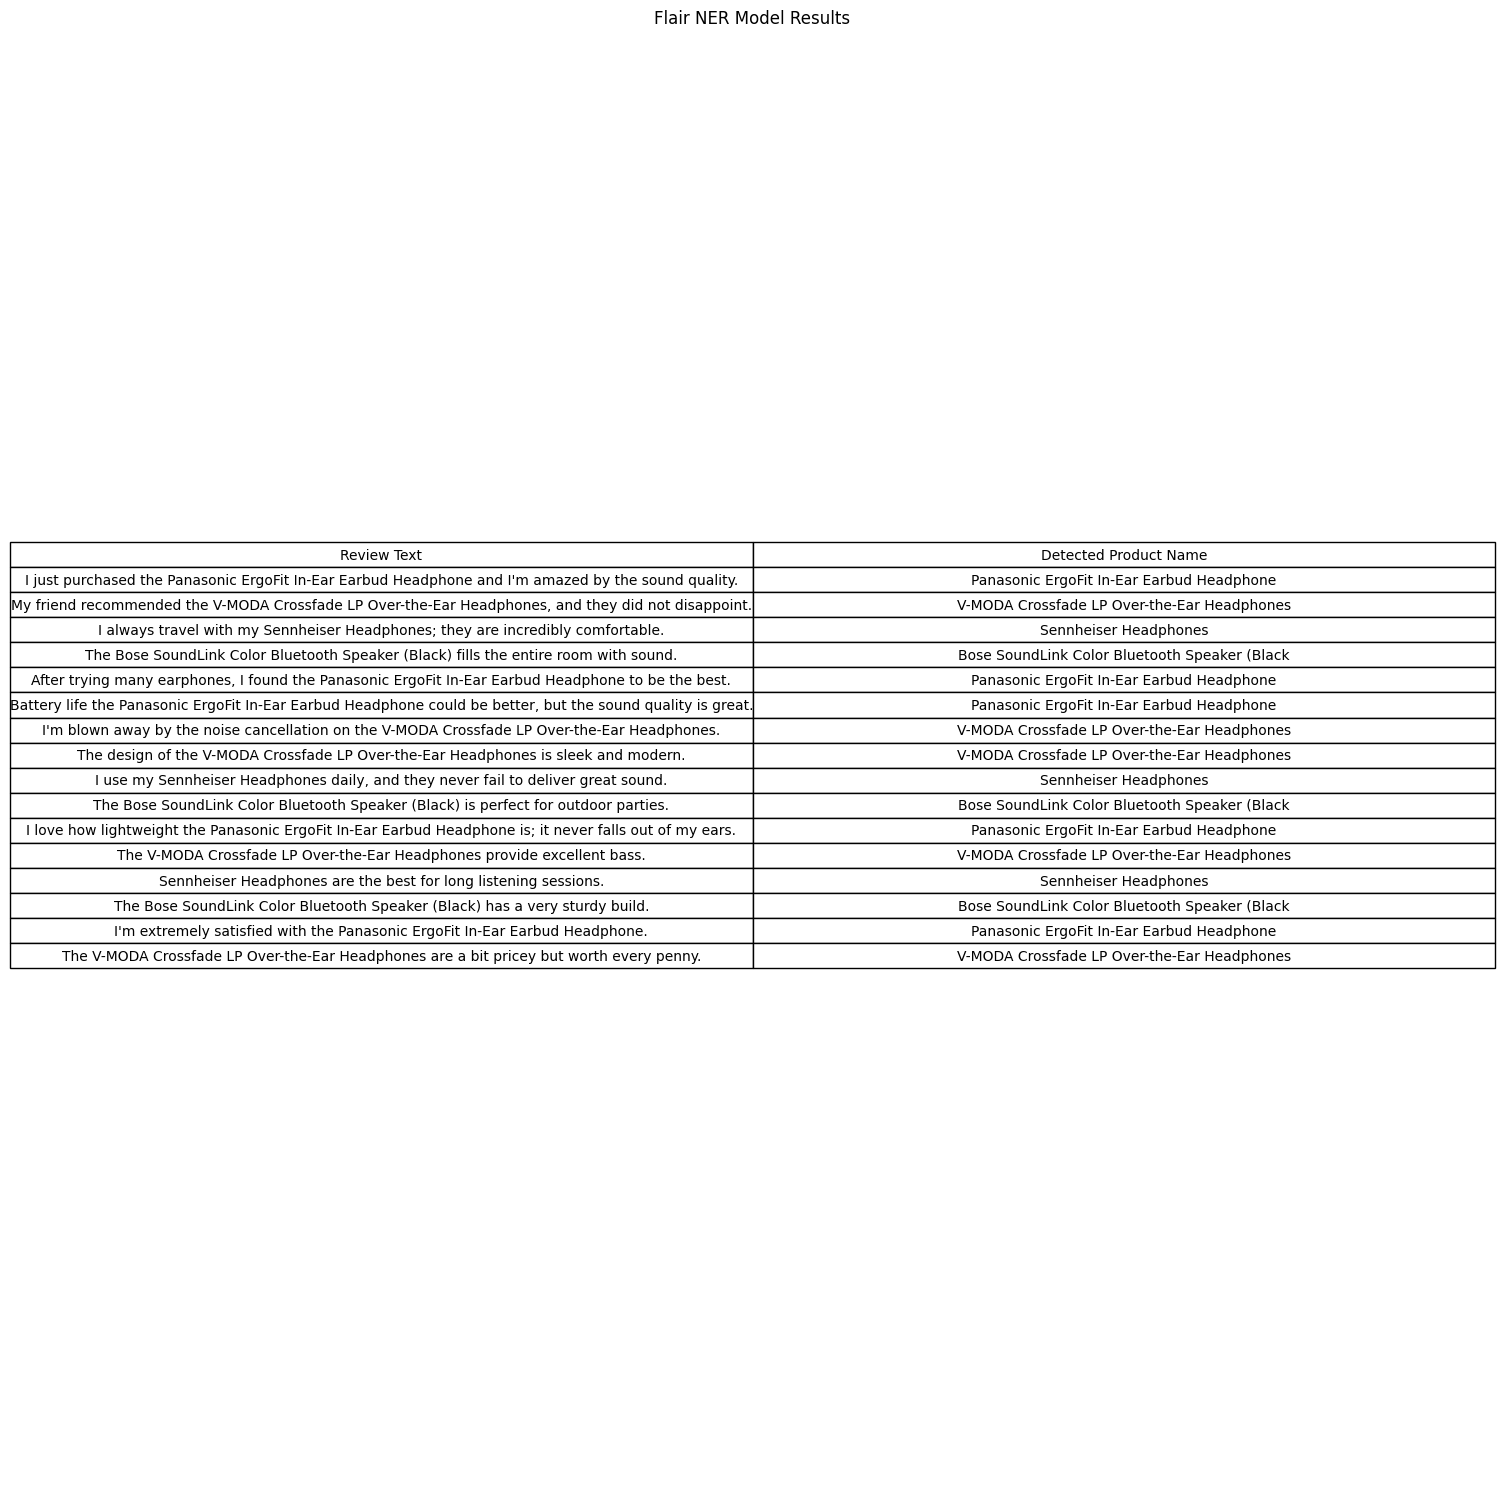

In [42]:
#15 example testing flair ner
import pandas as pd

# Test the model with sample texts
sample_texts = [
    "I just purchased the Panasonic ErgoFit In-Ear Earbud Headphone and I'm amazed by the sound quality.",
    "My friend recommended the V-MODA Crossfade LP Over-the-Ear Headphones, and they did not disappoint.",
    "I always travel with my Sennheiser Headphones; they are incredibly comfortable.",
    "The Bose SoundLink Color Bluetooth Speaker (Black) fills the entire room with sound.",
    "After trying many earphones, I found the Panasonic ErgoFit In-Ear Earbud Headphone to be the best.",
    "Battery life the Panasonic ErgoFit In-Ear Earbud Headphone could be better, but the sound quality is great.",
    "I'm blown away by the noise cancellation on the V-MODA Crossfade LP Over-the-Ear Headphones.",
    "The design of the V-MODA Crossfade LP Over-the-Ear Headphones is sleek and modern.",
    "I use my Sennheiser Headphones daily, and they never fail to deliver great sound.",
    "The Bose SoundLink Color Bluetooth Speaker (Black) is perfect for outdoor parties.",
    "I love how lightweight the Panasonic ErgoFit In-Ear Earbud Headphone is; it never falls out of my ears.",
    "The V-MODA Crossfade LP Over-the-Ear Headphones provide excellent bass.",
    "Sennheiser Headphones are the best for long listening sessions.",
    "The Bose SoundLink Color Bluetooth Speaker (Black) has a very sturdy build.",
    "I'm extremely satisfied with the Panasonic ErgoFit In-Ear Earbud Headphone.",
    "The V-MODA Crossfade LP Over-the-Ear Headphones are a bit pricey but worth every penny."
]

results = []

for text in sample_texts:
    sentence = Sentence(text)
    tagger.predict(sentence)
    product_names = [entity.text for entity in sentence.get_spans('ner') if entity.tag == 'PRODUCT']
    results.append({"Review Text": text, "Detected Product Name": ", ".join(product_names)})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Plot the table
plt.figure(figsize=(15, 15))
plt.axis('off')
table = plt.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title('Flair NER Model Results')
plt.tight_layout()
plt.savefig('flair_ner_results_table.png')
plt.show()


In [47]:
#16 reading data for sentiment analysis
drive.flush_and_unmount()
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/dataset/amazon_electronics.csv')


Mounted at /content/drive


In [48]:
#17 adding sentiment column
# adding a sentiment column to classify reviews as Positive or Negative
# Positive = 1
# Negative = 0

# Define a function to check the conditions and assign sentiment accordingly
def assign_sentiment(row):
    if row['total_votes'] > 0:
        if row['vine'] == 'Y':
            if row['star_rating'] == 5 and row['helpful_votes'] / row['total_votes'] >= 0.8:
                return 1
            else:
                return 0
        else:
            if row['star_rating'] >= 4 and row['helpful_votes'] / row['total_votes'] >= 0.5:
                return 1
            elif row['star_rating'] >= 4 and row['helpful_votes'] / row['total_votes'] < 0.5:
                return 0
            elif row['star_rating'] < 4 and row['helpful_votes'] / row['total_votes'] < 0.5:
                return 1
            else:
                return 0
    else:
        if row['vine'] == 'Y' and row['star_rating'] == 5:
            return 1
        elif row['star_rating'] >= 4:
            return 1
        else:
            return 0

# Apply the function to create the 'sentiment' column
data['sentiment'] = data.apply(assign_sentiment, axis=1)

# get unique values of product title column
data["product_title"].unique()


array(['yoomall 5M Antenna WIFI RP-SMA Female to Male Extensionl Cable',
       'Hosa GPM-103 3.5mm TRS to 1/4" TRS Adaptor',
       'Channel Master Titan 2 Antenna Preamplifier', ...,
       'Removable Car Stereo Faceplate Case (Discontinued by Manufacturer)',
       'Interact 62057 CD Jewel Box Replacement Cases (10-Pack)',
       'JVC RX-668 Audio/Video Receiver'], dtype=object)

Product with at least 20,000 occurrences and least difference in ratings <=3 and >3:
Product Title: Clip Plus 4 GB MP3 Player (Black)
Difference: 4509


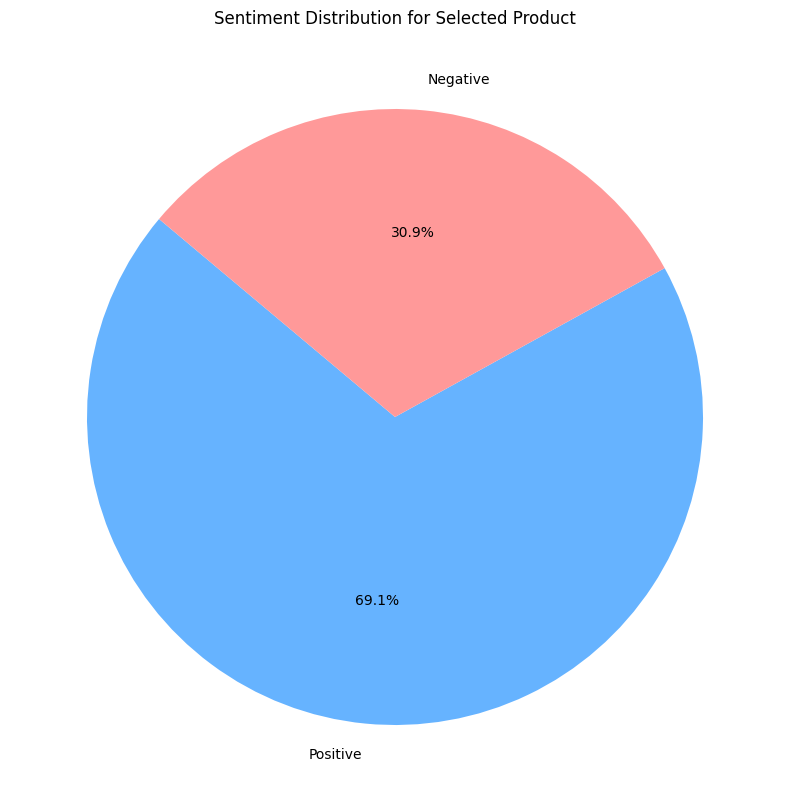

In [49]:
# Section 18: Data Selection for Sentiment Analysis
# Finding the best product to work with
product_occurrences = data['product_title'].value_counts()

popular_products = product_occurrences[product_occurrences >= 10000].index.tolist()

differences = {}
for product in popular_products:
    ratings_leq_3 = data[(data['product_title'] == product) & (data['star_rating'] <= 3)].shape[0]
    ratings_gt_3 = data[(data['product_title'] == product) & (data['star_rating'] > 3)].shape[0]
    difference = abs(ratings_leq_3 - ratings_gt_3)
    differences[product] = difference

least_diff_product = min(differences, key=differences.get)
least_diff_value = differences[least_diff_product]

print("Product with at least 20,000 occurrences and least difference in ratings <=3 and >3:")
print("Product Title:", least_diff_product)
print("Difference:", least_diff_value)

# Taking all the reviews of that product into consideration
prod_hosa = data.loc[data["product_title"] == least_diff_product]

# Count the number of positive and negative sentiments
sentiment_counts = prod_hosa['sentiment'].value_counts()

# Plot the pie chart
plt.figure(figsize=(10, 10))
plt.pie(sentiment_counts, labels=['Positive', 'Negative'], autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'], startangle=140)
plt.title('Sentiment Distribution for Selected Product')
plt.savefig('sentiment_distribution_pie_chart.png')
plt.show()


In [50]:
#19 data cleaning and processing for sentiment analysis

X = prod_hosa['review_body']
Y = prod_hosa['sentiment']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

# function to remove html elements from the reviews
def removeHTML(raw_text):
    clean_HTML = BeautifulSoup(raw_text, 'lxml').get_text()
    return clean_HTML

# function to remove special characters and numbers from the reviews4961
def removeSpecialChar(raw_text):
    clean_SpecialChar = re.sub("[^a-zA-Z]", " ", raw_text)
    return clean_SpecialChar

# function to convert all reviews into lower case
def toLowerCase(raw_text):
    clean_LowerCase = raw_text.lower().split()
    return( " ".join(clean_LowerCase))


# function to remove stop words from the reviews
def removeStopWords(raw_text):
    stops = set(stopwords.words("english"))
    words = [w for w in raw_text if not w in stops]
    return( " ".join(words))

# creating clean training set
nltk.download('stopwords')
X_train_cleaned = []

for val in X_train:
    val = removeHTML(val)
    val = removeSpecialChar(val)
    val = toLowerCase(val)
    removeStopWords(val)
    X_train_cleaned.append(val)

# creating clean testing set
X_test_cleaned = []

for val in X_test:
    val = removeHTML(val)
    val = removeSpecialChar(val)
    val = toLowerCase(val)
    removeStopWords(val)
    X_test_cleaned.append(val)

# Convert a collection of raw documents to a matrix of TF-IDF features.
tvec = TfidfVectorizer(use_idf=True,
strip_accents='ascii')

X_train_tvec = tvec.fit_transform(X_train_cleaned)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-50-7d1c39fd08a6>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_HTML = BeautifulSoup(raw_text, 'lxml').get_text()


In [51]:
#20 Support Vector Classifier training
# Define the Support Vector Classifier model
svr_lin = LinearSVC(multi_class='ovr', C=1.0, loss='squared_hinge', dual=False)

# Perform 4-fold cross-validation
kf_4 = KFold(n_splits=4, shuffle=True, random_state=42)
cv_scores_4 = cross_val_score(svr_lin, X_train_tvec, Y_train, cv=kf_4, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_4 = pd.DataFrame(index=range(1, 5))
cv_results_4['Accuracy'] = cv_scores_4
cv_results_4['Precision'] = cross_val_score(svr_lin, X_train_tvec, Y_train, cv=kf_4, scoring='precision_macro')
cv_results_4['Recall'] = cross_val_score(svr_lin, X_train_tvec, Y_train, cv=kf_4, scoring='recall_macro')
cv_results_4['F1 Score'] = cross_val_score(svr_lin, X_train_tvec, Y_train, cv=kf_4, scoring='f1_macro')

# Print 4-fold cross-validation results
print("4-Fold Cross-Validation Results:")
print(cv_results_4)

# Calculate and print mean scores for 4-fold cross-validation
print("\nMean Scores for 4-Fold Cross-Validation:")
print("Mean Accuracy:", cv_scores_4.mean())
print("Mean Precision:", cv_results_4['Precision'].mean())
print("Mean Recall:", cv_results_4['Recall'].mean())
print("Mean F1 Score:", cv_results_4['F1 Score'].mean())

# Perform 10-fold cross-validation
kf_10 = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores_10 = cross_val_score(svr_lin, X_train_tvec, Y_train, cv=kf_10, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_10 = pd.DataFrame(index=range(1, 11))
cv_results_10['Accuracy'] = cv_scores_10
cv_results_10['Precision'] = cross_val_score(svr_lin, X_train_tvec, Y_train, cv=kf_10, scoring='precision_macro')
cv_results_10['Recall'] = cross_val_score(svr_lin, X_train_tvec, Y_train, cv=kf_10, scoring='recall_macro')
cv_results_10['F1 Score'] = cross_val_score(svr_lin, X_train_tvec, Y_train, cv=kf_10, scoring='f1_macro')

# Print 10-fold cross-validation results
print("\n10-Fold Cross-Validation Results:")
print(cv_results_10)

# Calculate and print mean scores for 10-fold cross-validation
print("\nMean Scores for 10-Fold Cross-Validation:")
print("Mean Accuracy:", cv_scores_10.mean())
print("Mean Precision:", cv_results_10['Precision'].mean())
print("Mean Recall:", cv_results_10['Recall'].mean())
print("Mean F1 Score:", cv_results_10['F1 Score'].mean())

svr_train_f1 = cv_results_10['F1 Score'].mean()


4-Fold Cross-Validation Results:
   Accuracy  Precision    Recall  F1 Score
1  0.882003   0.868685  0.853936  0.860664
2  0.890917   0.876383  0.860926  0.868038
3  0.889219   0.877933  0.855259  0.865288
4  0.887473   0.875422  0.862278  0.868328

Mean Scores for 4-Fold Cross-Validation:
Mean Accuracy: 0.8874031699342873
Mean Precision: 0.8746055863043681
Mean Recall: 0.8580996044421434
Mean F1 Score: 0.865579697801547

10-Fold Cross-Validation Results:
    Accuracy  Precision    Recall  F1 Score
1   0.891835   0.873805  0.869338  0.871516
2   0.880170   0.865174  0.854933  0.859726
3   0.883351   0.866908  0.851421  0.858529
4   0.895966   0.881770  0.876136  0.878858
5   0.890658   0.880255  0.857129  0.867331
6   0.889597   0.886416  0.862084  0.872379
7   0.897028   0.878288  0.855845  0.866051
8   0.898089   0.890699  0.866739  0.877267
9   0.889597   0.875465  0.863713  0.869198
10  0.880042   0.867194  0.859094  0.862911

Mean Scores for 10-Fold Cross-Validation:
Mean Accuracy:

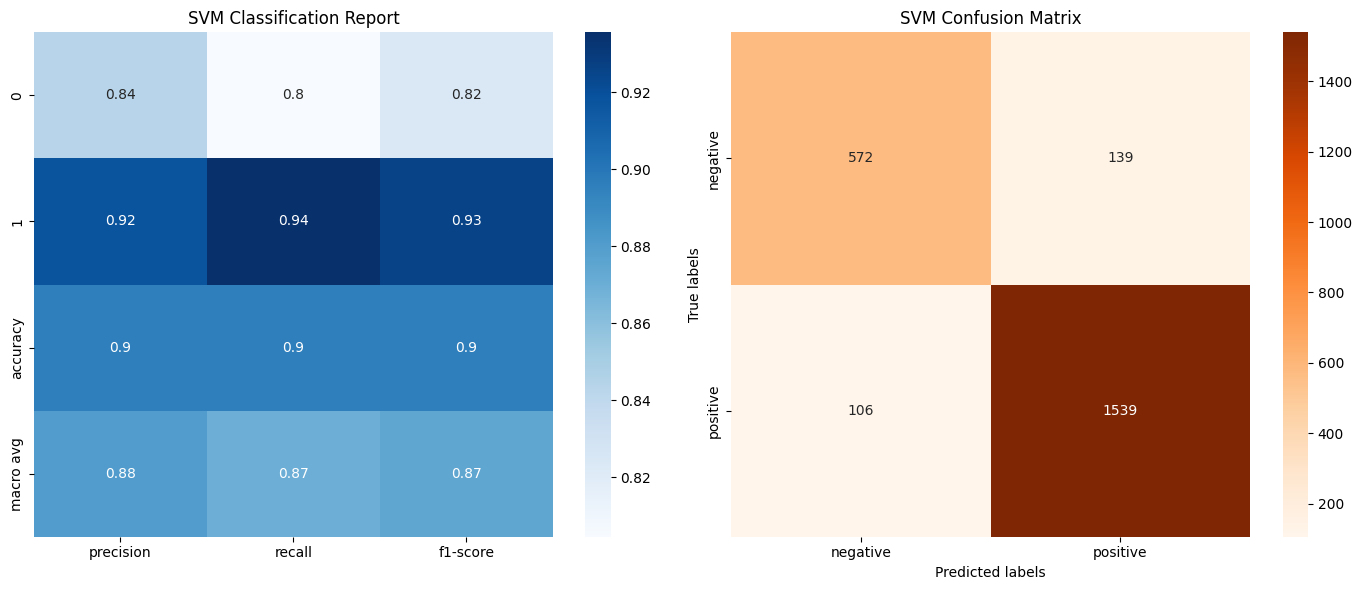

In [52]:
#21 Support Vector Classifier classification report and confusion matrix

svc=svr_lin
svc.fit(X_train_tvec, Y_train)
svc_predictions = svc.predict(tvec.transform(X_test_cleaned))
report = classification_report(Y_test, svc_predictions, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(4)
cm = confusion_matrix(Y_test, svc_predictions)

svc_train_f1 = cv_results_10['F1 Score'].mean()
svc_test_f1 = data_report.loc["weighted avg", "f1-score"]

# Plot classification report and confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Classification report
sns.heatmap(data_report.iloc[:-1, :-1], annot=True, cmap='Blues', ax=ax1)
ax1.set_title('SVM Classification Report')

# Confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Oranges', ax=ax2)
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_title('SVM Confusion Matrix')
ax2.xaxis.set_ticklabels(['negative', 'positive'])
ax2.yaxis.set_ticklabels(['negative', 'positive'])

plt.tight_layout()
plt.show()

In [87]:
#22 Support Vector Classifier sample testing

demo_reviews = [
    {"text": 'very disappointed in this product', "actual_sentiment": "negative"},
    {"text": 'Excellent product. Works well.', "actual_sentiment": "positive"}
]

# List to store results
results = []

# Perform predictions
for review in demo_reviews:
    demo_review_X_test = tvec.transform([review["text"]])
    predicted_sentiment = svr_lin.predict(demo_review_X_test)[0]
    predicted_sentiment_label = "positive" if predicted_sentiment == 1 else "negative"
    results.append([review["text"], review["actual_sentiment"], predicted_sentiment_label])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Text", "Actual Sentiment", "Predicted Sentiment"])

# Print the results table
print(results_df)

# Display the table
from IPython.display import display
display(results_df)


                                Text Actual Sentiment Predicted Sentiment
0  very disappointed in this product         negative            negative
1     Excellent product. Works well.         positive            positive


,Text,Actual Sentiment,Predicted Sentiment
0,very disappointed in this product,negative,negative
1,Excellent product. Works well.,positive,positive


In [53]:
#23 Random Forest training
# Random Forest model
random_forest = RandomForestClassifier(n_estimators=20,random_state=42)

# Perform 4-fold cross-validation
kf_4 = KFold(n_splits=4, shuffle=True, random_state=42)
cv_scores_4 = cross_val_score(random_forest, X_train_tvec, Y_train, cv=kf_4, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_4 = pd.DataFrame(index=range(1, 5))
cv_results_4['Accuracy'] = cv_scores_4
cv_results_4['Precision'] = cross_val_score(random_forest, X_train_tvec, Y_train, cv=kf_4, scoring='precision_macro')
cv_results_4['Recall'] = cross_val_score(random_forest, X_train_tvec, Y_train, cv=kf_4, scoring='recall_macro')
cv_results_4['F1 Score'] = cross_val_score(random_forest, X_train_tvec, Y_train, cv=kf_4, scoring='f1_macro')

# Print 4-fold cross-validation results
print("4-Fold Cross-Validation Results:")
print(cv_results_4)

# Calculate and print mean scores for 4-fold cross-validation
print("\nMean Scores for 4-Fold Cross-Validation:")
print("Mean Accuracy:", cv_scores_4.mean())
print("Mean Precision:", cv_results_4['Precision'].mean())
print("Mean Recall:", cv_results_4['Recall'].mean())
print("Mean F1 Score:", cv_results_4['F1 Score'].mean())

# Perform 10-fold cross-validation
kf_10 = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores_10 = cross_val_score(random_forest, X_train_tvec, Y_train, cv=kf_10, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_10 = pd.DataFrame(index=range(1, 11))
cv_results_10['Accuracy'] = cv_scores_10
cv_results_10['Precision'] = cross_val_score(random_forest, X_train_tvec, Y_train, cv=kf_10, scoring='precision_macro')
cv_results_10['Recall'] = cross_val_score(random_forest, X_train_tvec, Y_train, cv=kf_10, scoring='recall_macro')
cv_results_10['F1 Score'] = cross_val_score(random_forest, X_train_tvec, Y_train, cv=kf_10, scoring='f1_macro')

# Print 10-fold cross-validation results
print("\n10-Fold Cross-Validation Results:")
print(cv_results_10)

# Calculate and print mean scores for 10-fold cross-validation
print("\nMean Scores for 10-Fold Cross-Validation:")
print("Mean Accuracy:", cv_scores_10.mean())
print("Mean Precision:", cv_results_10['Precision'].mean())
print("Mean Recall:", cv_results_10['Recall'].mean())
print("Mean F1 Score:", cv_results_10['F1 Score'].mean())


4-Fold Cross-Validation Results:
   Accuracy  Precision    Recall  F1 Score
1  0.846774   0.849209  0.785740  0.806675
2  0.849745   0.845930  0.785244  0.806279
3  0.846350   0.850304  0.775412  0.799162
4  0.846709   0.849072  0.788565  0.808676

Mean Scores for 4-Fold Cross-Validation:
Mean Accuracy: 0.847394599865186
Mean Precision: 0.8486284435641696
Mean Recall: 0.7837401090313723
Mean F1 Score: 0.8051978606629093

10-Fold Cross-Validation Results:
    Accuracy  Precision    Recall  F1 Score
1   0.853659   0.844036  0.798780  0.815914
2   0.818664   0.813704  0.750776  0.769932
3   0.846235   0.835218  0.785794  0.803937
4   0.855626   0.863703  0.795250  0.817625
5   0.846072   0.835461  0.789070  0.806265
6   0.840764   0.851006  0.785381  0.805308
7   0.855626   0.847113  0.771103  0.797075
8   0.851380   0.852707  0.789510  0.810862
9   0.841826   0.851234  0.770072  0.794243
10  0.836518   0.836650  0.783394  0.800993

Mean Scores for 10-Fold Cross-Validation:
Mean Accuracy:

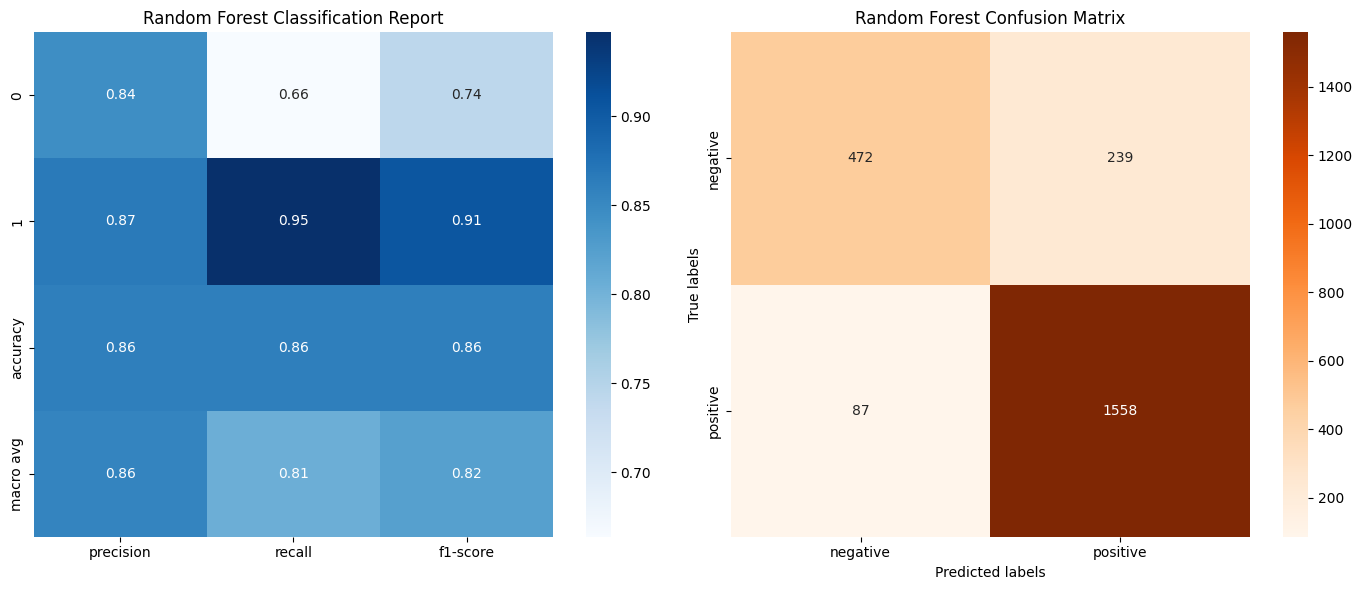

In [54]:
# Section 24: Random Forest Model Evaluation
random_forest.fit(X_train_tvec, Y_train)
ranfrst_predictions = random_forest.predict(tvec.transform(X_test_cleaned))
report = classification_report(Y_test, ranfrst_predictions, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(4)
cm = confusion_matrix(Y_test, ranfrst_predictions)

rf_train_f1 = cv_results_10['F1 Score'].mean()
rf_test_f1 = data_report.loc["weighted avg", "f1-score"]

# Plot classification report and confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Classification report
sns.heatmap(data_report.iloc[:-1, :-1], annot=True, cmap='Blues', ax=ax1)
ax1.set_title('Random Forest Classification Report')

# Confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Oranges', ax=ax2)
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_title('Random Forest Confusion Matrix')
ax2.xaxis.set_ticklabels(['negative', 'positive'])
ax2.yaxis.set_ticklabels(['negative', 'positive'])

plt.tight_layout()
plt.show()

In [85]:
#25 Random Forest Example Testing

demo_reviews = [
    {"text": 'do not buy fake product', "actual_sentiment": "negative"},
    {"text": 'original product great performance', "actual_sentiment": "positive"}
]

# List to store results
results = []

# Perform predictions
for review in demo_reviews:
    demo_review_X_test = tvec.transform([review["text"]])
    predicted_sentiment = random_forest.predict(demo_review_X_test)[0]
    predicted_sentiment_label = "positive" if predicted_sentiment == 1 else "negative"
    results.append([review["text"], review["actual_sentiment"], predicted_sentiment_label])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Text", "Actual Sentiment", "Predicted Sentiment"])

# Print the results table
print(results_df)

# Display the table
from IPython.display import display
display(results_df)

                                 Text Actual Sentiment Predicted Sentiment
0             do not buy fake product         negative            negative
1  original product great performance         positive            positive


,Text,Actual Sentiment,Predicted Sentiment
0,do not buy fake product,negative,negative
1,original product great performance,positive,positive


In [55]:
#26 Logistic Regression training
# Define the Logistic Regression model
logistic_classifier = LogisticRegression(random_state=42)

# Perform 4-fold cross-validation
kf_4 = KFold(n_splits=4, shuffle=True, random_state=42)
cv_scores_4 = cross_val_score(logistic_classifier, X_train_tvec, Y_train, cv=kf_4, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_4 = pd.DataFrame(index=range(1, 5))
cv_results_4['Accuracy'] = cv_scores_4
cv_results_4['Precision'] = cross_val_score(logistic_classifier, X_train_tvec, Y_train, cv=kf_4, scoring='precision_macro')
cv_results_4['Recall'] = cross_val_score(logistic_classifier, X_train_tvec, Y_train, cv=kf_4, scoring='recall_macro')
cv_results_4['F1 Score'] = cross_val_score(logistic_classifier, X_train_tvec, Y_train, cv=kf_4, scoring='f1_macro')

# Print 4-fold cross-validation results
print("4-Fold Cross-Validation Results for Logistic Regression Classifier:")
print(cv_results_4)

# Calculate and print mean scores for 4-fold cross-validation
print("\nMean Scores for 4-Fold Cross-Validation:")
print("Mean Accuracy:", cv_scores_4.mean())
print("Mean Precision:", cv_results_4['Precision'].mean())
print("Mean Recall:", cv_results_4['Recall'].mean())
print("Mean F1 Score:", cv_results_4['F1 Score'].mean())

# Perform 10-fold cross-validation
kf_10 = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores_10 = cross_val_score(logistic_classifier, X_train_tvec, Y_train, cv=kf_10, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_10 = pd.DataFrame(index=range(1, 11))
cv_results_10['Accuracy'] = cv_scores_10
cv_results_10['Precision'] = cross_val_score(logistic_classifier, X_train_tvec, Y_train, cv=kf_10, scoring='precision_macro')
cv_results_10['Recall'] = cross_val_score(logistic_classifier, X_train_tvec, Y_train, cv=kf_10, scoring='recall_macro')
cv_results_10['F1 Score'] = cross_val_score(logistic_classifier, X_train_tvec, Y_train, cv=kf_10, scoring='f1_macro')

# Print 10-fold cross-validation results
print("\n10-Fold Cross-Validation Results for Logistic Regression Classifier:")
print(cv_results_10)

# Calculate and print mean scores for 10-fold cross-validation
print("\nMean Scores for 10-Fold Cross-Validation:")
print("Mean Accuracy:", cv_scores_10.mean())
print("Mean Precision:", cv_results_10['Precision'].mean())
print("Mean Recall:", cv_results_10['Recall'].mean())
print("Mean F1 Score:", cv_results_10['F1 Score'].mean())


4-Fold Cross-Validation Results for Logistic Regression Classifier:
   Accuracy  Precision    Recall  F1 Score
1  0.875637   0.870820  0.834404  0.849034
2  0.891766   0.889630  0.847999  0.864876
3  0.888795   0.892553  0.839655  0.859897
4  0.878132   0.876173  0.837414  0.852734

Mean Scores for 4-Fold Cross-Validation:
Mean Accuracy: 0.883582144698092
Mean Precision: 0.8822940731685639
Mean Recall: 0.8398678334338834
Mean F1 Score: 0.8566351448717892

10-Fold Cross-Validation Results for Logistic Regression Classifier:
    Accuracy  Precision    Recall  F1 Score
1   0.888653   0.879904  0.851372  0.863622
2   0.869565   0.868611  0.822981  0.840243
3   0.871686   0.861553  0.825042  0.839934
4   0.902335   0.903337  0.867272  0.882132
5   0.888535   0.885626  0.845884  0.862011
6   0.882166   0.889434  0.843172  0.860255
7   0.897028   0.891078  0.841153  0.861520
8   0.891720   0.898937  0.844204  0.864854
9   0.888535   0.886459  0.847965  0.863564
10  0.883227   0.879538  0.8516

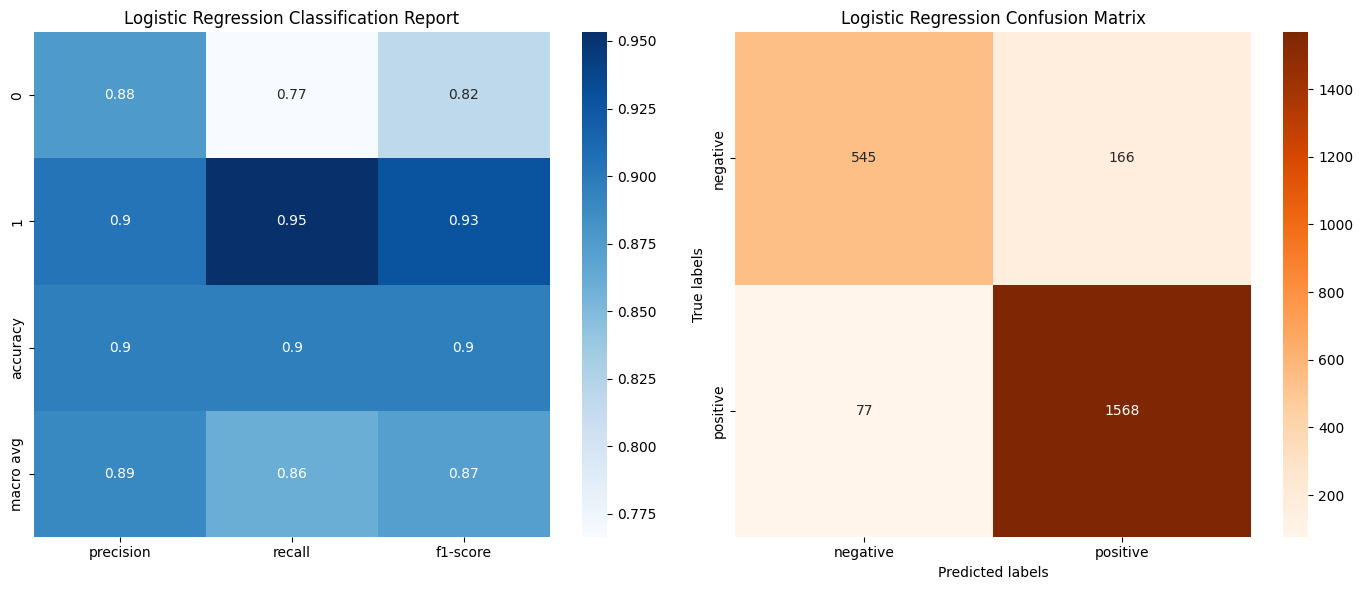

In [56]:
#27 logistic regression classification report and confusion matrix
lr = LogisticRegression(random_state=42)
lr.fit(X_train_tvec, Y_train)
lr_predictions = lr.predict(tvec.transform(X_test_cleaned))
report = classification_report(Y_test, lr_predictions, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(4)
cm = confusion_matrix(Y_test, lr_predictions)

lr_train_f1 = cv_results_10['F1 Score'].mean()
lr_test_f1 = data_report.loc["weighted avg", "f1-score"]

# Plot classification report and confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Classification report
sns.heatmap(data_report.iloc[:-1, :-1], annot=True, cmap='Blues', ax=ax1)
ax1.set_title('Logistic Regression Classification Report')

# Confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Oranges', ax=ax2)
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_title('Logistic Regression Confusion Matrix')
ax2.xaxis.set_ticklabels(['negative', 'positive'])
ax2.yaxis.set_ticklabels(['negative', 'positive'])

plt.tight_layout()
plt.show()


In [84]:
#28 logistic regression sample testing
demo_reviews = [
    {"text": 'poco x3 is the worst', "actual_sentiment": "negative"},
    {"text": 'poco f3 has long battery life', "actual_sentiment": "positive"}
]

# List to store results
results = []

# Perform predictions
for review in demo_reviews:
    demo_review_X_test = tvec.transform([review["text"]])
    predicted_sentiment = lr.predict(demo_review_X_test)[0]
    predicted_sentiment_label = "positive" if predicted_sentiment == 1 else "negative"
    results.append([review["text"], review["actual_sentiment"], predicted_sentiment_label])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Text", "Actual Sentiment", "Predicted Sentiment"])

# Print the results table
print(results_df)

# Display the table
from IPython.display import display
display(results_df)

                            Text Actual Sentiment Predicted Sentiment
0           poco x3 is the worst         negative            negative
1  poco f3 has long battery life         positive            positive


,Text,Actual Sentiment,Predicted Sentiment
0,poco x3 is the worst,negative,negative
1,poco f3 has long battery life,positive,positive


In [57]:
#29 multinomial naive bayes training
from sklearn.naive_bayes import MultinomialNB

# Define the Multinomial Naive Bayes classifier model
nb_classifier = MultinomialNB()

# Perform 4-fold cross-validation
kf_4 = KFold(n_splits=4, shuffle=True, random_state=42)
cv_scores_4 = cross_val_score(nb_classifier, X_train_tvec, Y_train, cv=kf_4, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_4 = pd.DataFrame(index=range(1, 5))
cv_results_4['Accuracy'] = cv_scores_4
cv_results_4['Precision'] = cross_val_score(nb_classifier, X_train_tvec, Y_train, cv=kf_4, scoring='precision_macro')
cv_results_4['Recall'] = cross_val_score(nb_classifier, X_train_tvec, Y_train, cv=kf_4, scoring='recall_macro')
cv_results_4['F1 Score'] = cross_val_score(nb_classifier, X_train_tvec, Y_train, cv=kf_4, scoring='f1_macro')

# Print 4-fold cross-validation results
print("4-Fold Cross-Validation Results for Multinomial Naive Bayes Classifier:")
print(cv_results_4)

# Calculate and print mean scores for 4-fold cross-validation
print("\nMean Scores for 4-Fold Cross-Validation:")
print("Mean Accuracy:", cv_scores_4.mean())
print("Mean Precision:", cv_results_4['Precision'].mean())
print("Mean Recall:", cv_results_4['Recall'].mean())
print("Mean F1 Score:", cv_results_4['F1 Score'].mean())

# Perform 10-fold cross-validation
kf_10 = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores_10 = cross_val_score(nb_classifier, X_train_tvec, Y_train, cv=kf_10, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_10 = pd.DataFrame(index=range(1, 11))
cv_results_10['Accuracy'] = cv_scores_10
cv_results_10['Precision'] = cross_val_score(nb_classifier, X_train_tvec, Y_train, cv=kf_10, scoring='precision_macro')
cv_results_10['Recall'] = cross_val_score(nb_classifier, X_train_tvec, Y_train, cv=kf_10, scoring='recall_macro')
cv_results_10['F1 Score'] = cross_val_score(nb_classifier, X_train_tvec, Y_train, cv=kf_10, scoring='f1_macro')

# Print 10-fold cross-validation results
print("\n10-Fold Cross-Validation Results for Multinomial Naive Bayes Classifier:")
print(cv_results_10)

# Calculate and print mean scores for 10-fold cross-validation
print("\nMean Scores for 10-Fold Cross-Validation:")
print("Mean Accuracy:", cv_scores_10.mean())
print("Mean Precision:", cv_results_10['Precision'].mean())
print("Mean Recall:", cv_results_10['Recall'].mean())
print("Mean F1 Score:", cv_results_10['F1 Score'].mean())


4-Fold Cross-Validation Results for Multinomial Naive Bayes Classifier:
   Accuracy  Precision    Recall  F1 Score
1  0.774618   0.843646  0.648835  0.660234
2  0.789898   0.857502  0.657961  0.675467
3  0.784380   0.866865  0.648492  0.662449
4  0.769002   0.847045  0.642887  0.651098

Mean Scores for 4-Fold Cross-Validation:
Mean Accuracy: 0.7794746394443063
Mean Precision: 0.8537644639421593
Mean Recall: 0.6495438121214783
Mean F1 Score: 0.6623119735632733

10-Fold Cross-Validation Results for Multinomial Naive Bayes Classifier:
    Accuracy  Precision    Recall  F1 Score
1   0.806999   0.867821  0.688807  0.713349
2   0.775186   0.825754  0.656235  0.669648
3   0.797455   0.869153  0.667740  0.688324
4   0.809979   0.867380  0.705975  0.730747
5   0.785563   0.845308  0.657078  0.673422
6   0.787686   0.871229  0.685111  0.701581
7   0.808917   0.864036  0.655783  0.679931
8   0.801486   0.883950  0.680738  0.702701
9   0.796178   0.854297  0.679843  0.700725
10  0.772824   0.83362

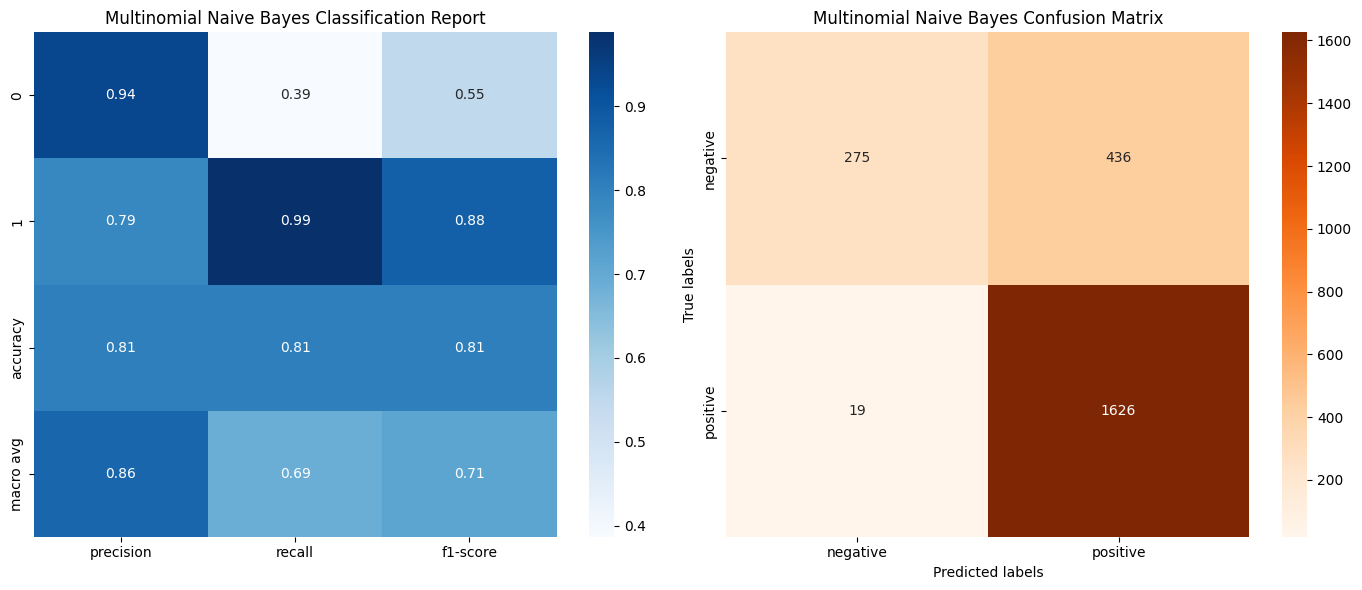

In [58]:
# Section 30: Multinomial Naive Bayes Model Evaluation
nb = MultinomialNB()
nb.fit(X_train_tvec, Y_train)
nb_predictions = nb.predict(tvec.transform(X_test_cleaned))
report = classification_report(Y_test, nb_predictions, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(4)
cm = confusion_matrix(Y_test, nb_predictions)

nb_train_f1 = cv_results_10['F1 Score'].mean()
nb_test_f1 = data_report.loc["weighted avg", "f1-score"]

# Plot classification report and confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Classification report
sns.heatmap(data_report.iloc[:-1, :-1], annot=True, cmap='Blues', ax=ax1)
ax1.set_title('Multinomial Naive Bayes Classification Report')

# Confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Oranges', ax=ax2)
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_title('Multinomial Naive Bayes Confusion Matrix')
ax2.xaxis.set_ticklabels(['negative', 'positive'])
ax2.yaxis.set_ticklabels(['negative', 'positive'])

plt.tight_layout()
plt.show()


In [80]:
# Section 31: nb Sample Testing

# Sample reviews for testing
demo_reviews = [
    {"text": 'iphone13 is a bad product dont buy', "actual_sentiment": "negative"},
    {"text": 'iphone14 is a good product, should buy', "actual_sentiment": "positive"}
]

# List to store results
results = []

# Perform predictions
for review in demo_reviews:
    demo_review_X_test = tvec.transform([review["text"]])
    predicted_sentiment = nb.predict(demo_review_X_test)[0]
    predicted_sentiment_label = "positive" if predicted_sentiment == 1 else "negative"
    results.append([review["text"], review["actual_sentiment"], predicted_sentiment_label])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Text", "Actual Sentiment", "Predicted Sentiment"])

# Print the results table
print(results_df)

# Display the table
from IPython.display import display
display(results_df)


                                     Text Actual Sentiment Predicted Sentiment
0      iphone13 is a bad product dont buy         negative            positive
1  iphone14 is a good product, should buy         positive            positive


,Text,Actual Sentiment,Predicted Sentiment
0,iphone13 is a bad product dont buy,negative,positive
1,"iphone14 is a good product, should buy",positive,positive


In [59]:
#32 xgboost training

# XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)

# Perform 4-fold cross-validation
kf_4 = KFold(n_splits=4, shuffle=True, random_state=42)
cv_scores_4_xgb = cross_val_score(xgb_model, X_train_tvec, Y_train, cv=kf_4, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_4_xgb = pd.DataFrame(index=range(1, 5))
cv_results_4_xgb['Accuracy'] = cv_scores_4_xgb
cv_results_4_xgb['Precision'] = cross_val_score(xgb_model, X_train_tvec, Y_train, cv=kf_4, scoring='precision_macro')
cv_results_4_xgb['Recall'] = cross_val_score(xgb_model, X_train_tvec, Y_train, cv=kf_4, scoring='recall_macro')
cv_results_4_xgb['F1 Score'] = cross_val_score(xgb_model, X_train_tvec, Y_train, cv=kf_4, scoring='f1_macro')

# Print 4-fold cross-validation results
print("4-Fold Cross-Validation Results (XGBoost):")
print(cv_results_4_xgb)

# Calculate and print mean scores for 4-fold cross-validation
print("\nMean Scores for 4-Fold Cross-Validation (XGBoost):")
print("Mean Accuracy:", cv_scores_4_xgb.mean())
print("Mean Precision:", cv_results_4_xgb['Precision'].mean())
print("Mean Recall:", cv_results_4_xgb['Recall'].mean())
print("Mean F1 Score:", cv_results_4_xgb['F1 Score'].mean())

# Perform 10-fold cross-validation
kf_10 = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores_10_xgb = cross_val_score(xgb_model, X_train_tvec, Y_train, cv=kf_10, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_10_xgb = pd.DataFrame(index=range(1, 11))
cv_results_10_xgb['Accuracy'] = cv_scores_10_xgb
cv_results_10_xgb['Precision'] = cross_val_score(xgb_model, X_train_tvec, Y_train, cv=kf_10, scoring='precision_macro')
cv_results_10_xgb['Recall'] = cross_val_score(xgb_model, X_train_tvec, Y_train, cv=kf_10, scoring='recall_macro')
cv_results_10_xgb['F1 Score'] = cross_val_score(xgb_model, X_train_tvec, Y_train, cv=kf_10, scoring='f1_macro')

# Print 10-fold cross-validation results
print("\n10-Fold Cross-Validation Results (XGBoost):")
print(cv_results_10_xgb)

# Calculate and print mean scores for 10-fold cross-validation
print("\nMean Scores for 10-Fold Cross-Validation (XGBoost):")
print("Mean Accuracy:", cv_scores_10_xgb.mean())
print("Mean Precision:", cv_results_10_xgb['Precision'].mean())
print("Mean Recall:", cv_results_10_xgb['Recall'].mean())
print("Mean F1 Score:", cv_results_10_xgb['F1 Score'].mean())


4-Fold Cross-Validation Results (XGBoost):
   Accuracy  Precision    Recall  F1 Score
1  0.858234   0.847407  0.815525  0.828427
2  0.880306   0.870203  0.838991  0.852159
3  0.873514   0.865683  0.827495  0.842903
4  0.873461   0.867577  0.834689  0.848053

Mean Scores for 4-Fold Cross-Validation (XGBoost):
Mean Accuracy: 0.8713787628100454
Mean Precision: 0.8627173270735582
Mean Recall: 0.8291748743979933
Mean F1 Score: 0.8428854760801501

10-Fold Cross-Validation Results (XGBoost):
    Accuracy  Precision    Recall  F1 Score
1   0.890774   0.882612  0.853876  0.866220
2   0.843054   0.825889  0.802676  0.812436
3   0.863203   0.850344  0.814965  0.829351
4   0.878981   0.868938  0.845684  0.855754
5   0.878981   0.870795  0.837060  0.851036
6   0.870488   0.867914  0.835954  0.848625
7   0.875796   0.862524  0.811885  0.831992
8   0.880042   0.875264  0.837629  0.852841
9   0.873673   0.857688  0.842796  0.849580
10  0.856688   0.843907  0.826170  0.833887

Mean Scores for 10-Fold C

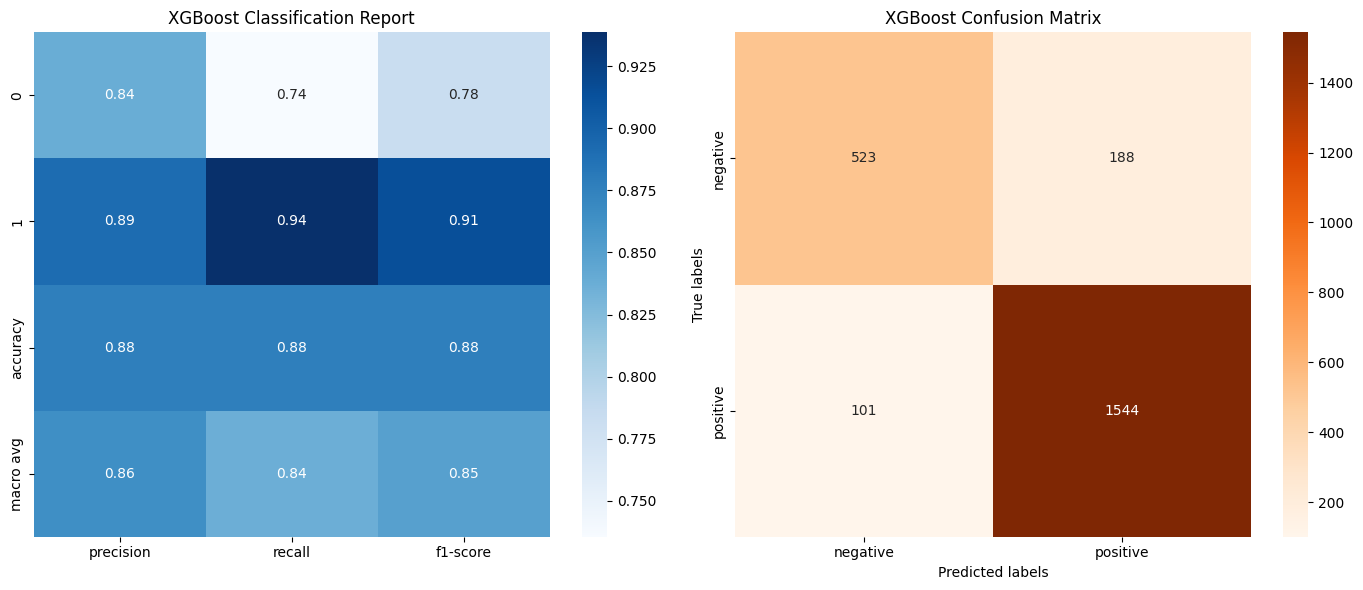

In [60]:
#33 xgboost classification report and confusion matrix
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_tvec, Y_train)
xgb_predictions = xgb_model.predict(tvec.transform(X_test_cleaned))
report = classification_report(Y_test, xgb_predictions, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(4)
cm = confusion_matrix(Y_test, xgb_predictions)

xgb_train_f1 = cv_results_10['F1 Score'].mean()
xgb_test_f1 = data_report.loc["weighted avg", "f1-score"]

# Plot classification report and confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Classification report
sns.heatmap(data_report.iloc[:-1, :-1], annot=True, cmap='Blues', ax=ax1)
ax1.set_title('XGBoost Classification Report')

# Confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Oranges', ax=ax2)
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_title('XGBoost Confusion Matrix')
ax2.xaxis.set_ticklabels(['negative', 'positive'])
ax2.yaxis.set_ticklabels(['negative', 'positive'])

plt.tight_layout()
plt.show()

In [64]:
joblib.dump(xgb_model,'xgboost_model.pkl')
joblib.dump(svr_lin,'svc_model.pkl')
joblib.dump(lr,'lr_model.pkl')
joblib.dump(nb,'nb_model.pkl')
joblib.dump(random_forest,'rf_model.pkl')

['rf_model.pkl']

In [77]:
# Section 34: XGBoost Sample Testing

# Sample reviews for testing
demo_reviews = [
    {"text": 'Defective. Bad. Stopped working after one day use', "actual_sentiment": "negative"},
    {"text": 'Good product. highly recommend buying.', "actual_sentiment": "positive"}
]

# List to store results
results = []

# Perform predictions
for review in demo_reviews:
    demo_review_X_test = tvec.transform([review["text"]])
    predicted_sentiment = xgb_model.predict(demo_review_X_test)[0]
    predicted_sentiment_label = "positive" if predicted_sentiment == 1 else "negative"
    results.append([review["text"], review["actual_sentiment"], predicted_sentiment_label])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Text", "Actual Sentiment", "Predicted Sentiment"])

# Print the results table
print(results_df)

# Display the table
from IPython.display import display
display(results_df)


                                                Text Actual Sentiment  \
0  Defective. Bad. Stopped working after one day use         negative   
1             Good product. highly recommend buying.         positive   

  Predicted Sentiment  
0            negative  
1            positive  


,Text,Actual Sentiment,Predicted Sentiment
0,Defective. Bad. Stopped working after one day use,negative,negative
1,Good product. highly recommend buying.,positive,positive


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


2024-05-18 01:55:38,157 SequenceTagger predicts: Dictionary with 7 tags: O, S-PRODUCT, B-PRODUCT, E-PRODUCT, I-PRODUCT, <START>, <STOP>


<ipython-input-66-835567ef88d1>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ner_models, y=ner_test_f1, palette='viridis')


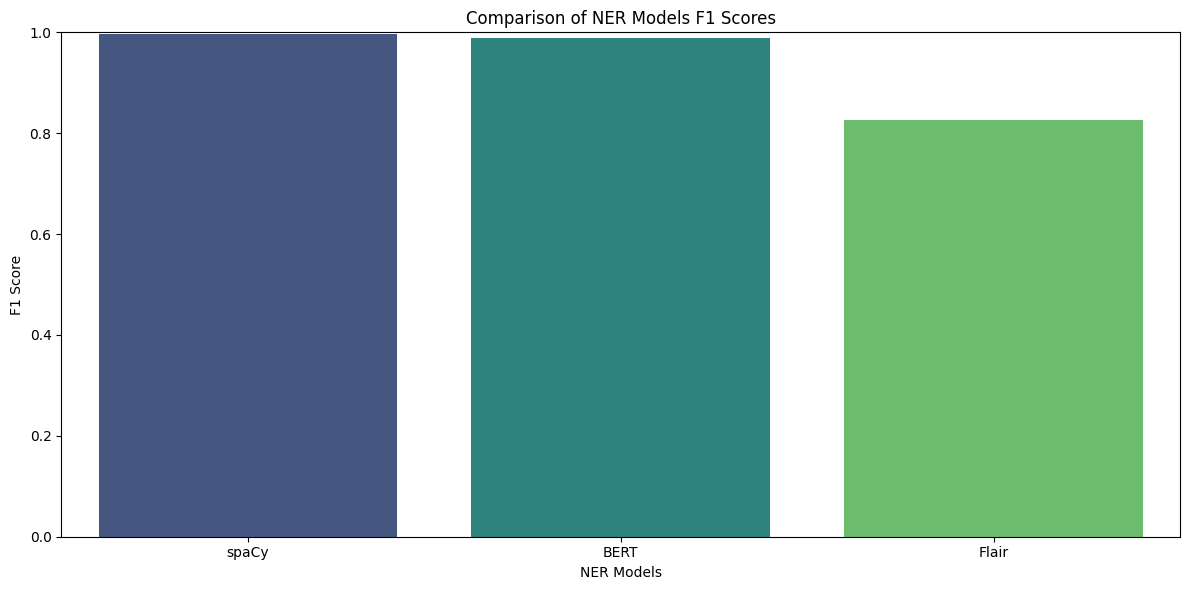

<ipython-input-66-835567ef88d1>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=senti_models, y=senti_test_f1, palette='viridis')


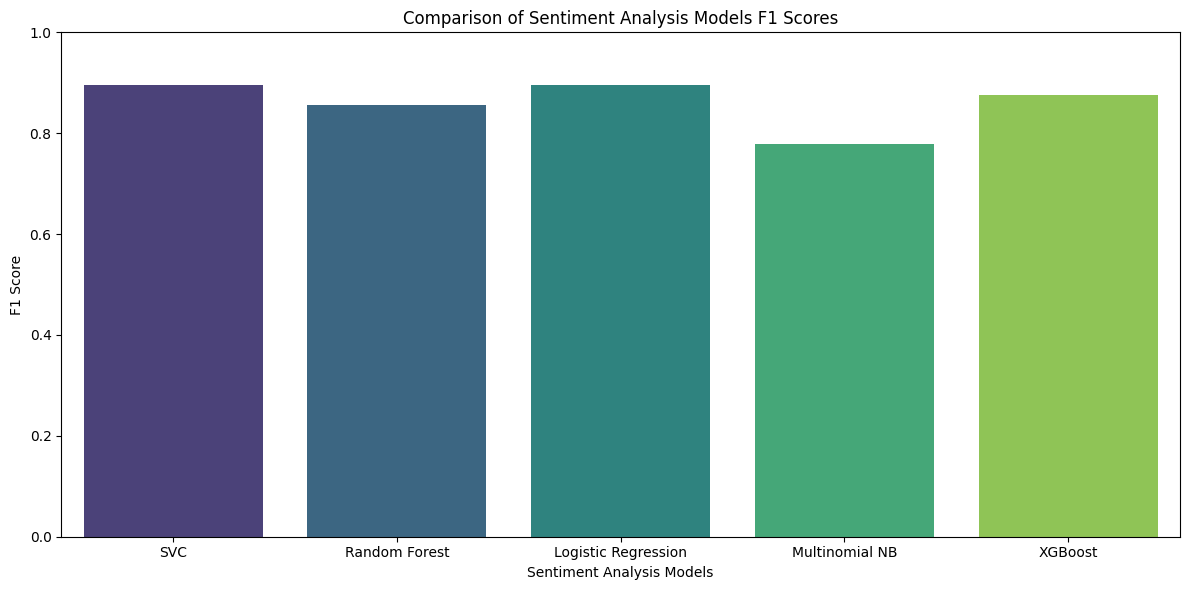

Best NER Model: spaCy
Best Sentiment Analysis Model: SVC


['best_senti_model.joblib']

In [66]:
# 35 Comparison of NER models and sentiment analysis models

# Load the trained NER models
import joblib
nlp_spacy = spacy.load('spacy_ner_model')
bert_ner_model = BertForTokenClassification.from_pretrained('bert_ner_model')
flair_ner_model = SequenceTagger.load('resources/taggers/ner/best-model.pt')

# NER model names and F1 scores
ner_models = ['spaCy', 'BERT', 'Flair']
ner_train_f1 = [spacy_train_f1, bert_train_f1, flair_train_f1]
ner_test_f1 = [spacy_test_f1, bert_test_f1, flair_test_f1]

# Plot comparison of NER models F1 scores
plt.figure(figsize=(12, 6))
sns.barplot(x=ner_models, y=ner_test_f1, palette='viridis')
plt.title('Comparison of NER Models F1 Scores')
plt.xlabel('NER Models')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('ner_models_f1_comparison.png')
plt.show()

# Load the trained sentiment analysis models
svc_model = joblib.load('svc_model.pkl')
rf_model = joblib.load('rf_model.pkl')
lr_model = joblib.load('lr_model.pkl')
nb_model = joblib.load('nb_model.pkl')
xgb_model = joblib.load('xgboost_model.pkl')

# Sentiment analysis model names and F1 scores
senti_models = ['SVC', 'Random Forest', 'Logistic Regression', 'Multinomial NB', 'XGBoost']
senti_train_f1 = [svc_train_f1, rf_train_f1, lr_train_f1, nb_train_f1, xgb_train_f1]
senti_test_f1 = [svc_test_f1, rf_test_f1, lr_test_f1, nb_test_f1, xgb_test_f1]

# Plot comparison of sentiment analysis models F1 scores
plt.figure(figsize=(12, 6))
sns.barplot(x=senti_models, y=senti_test_f1, palette='viridis')
plt.title('Comparison of Sentiment Analysis Models F1 Scores')
plt.xlabel('Sentiment Analysis Models')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('senti_models_f1_comparison.png')
plt.show()

# Determine the best models
best_ner_model_name = ner_models[np.argmax(ner_test_f1)]
best_senti_model_name = senti_models[np.argmax(senti_test_f1)]

print(f"Best NER Model: {best_ner_model_name}")
print(f"Best Sentiment Analysis Model: {best_senti_model_name}")

# Save the best models
if best_ner_model_name == 'spaCy':
    best_ner_model = {'type': 'spacy', 'model': nlp_spacy}
elif best_ner_model_name == 'BERT':
    best_ner_model = {'type': 'bert', 'model': bert_ner_model, 'tokenizer': BertTokenizer.from_pretrained('bert_ner_model')}
else:
    best_ner_model = {'type': 'flair', 'model': flair_ner_model}

joblib.dump(best_ner_model, 'best_ner_model.joblib')

if best_senti_model_name == 'SVC':
    best_senti_model = svc_model
elif best_senti_model_name == 'Random Forest':
    best_senti_model = rf_model
elif best_senti_model_name == 'Logistic Regression':
    best_senti_model = lr_model
elif best_senti_model_name == 'Multinomial NB':
    best_senti_model = nb_model
else:
    best_senti_model = xgb_model

joblib.dump(best_senti_model, 'best_senti_model.joblib')


In [71]:
joblib.dump(tvec,'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [76]:
# Section 36: Merging the Best NER and Sentiment Analysis Models

# Load the best NER model
best_ner_model = joblib.load('best_ner_model.joblib')
ner_model_type = best_ner_model["type"]
ner_model = best_ner_model["model"]
tokenizer = best_ner_model.get("tokenizer", None)

# Load the best sentiment analysis model and its vectorizer
best_sentiment_model = joblib.load('best_senti_model.joblib')
vectorizer = joblib.load('tfidf_vectorizer.pkl')  # Assuming you saved the vectorizer earlier

class CombinedModel:
    def __init__(self, ner_model, sentiment_model, ner_model_type, tokenizer=None, vectorizer=None):
        self.ner_model = ner_model
        self.sentiment_model = sentiment_model
        self.ner_model_type = ner_model_type
        self.tokenizer = tokenizer
        self.vectorizer = vectorizer

    def predict(self, text):
        # NER prediction
        if self.ner_model_type == 'spacy':
            doc = self.ner_model(text)
            products = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ == "PRODUCT"]
        elif self.ner_model_type == 'bert':
            encoding = self.tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
            with torch.no_grad():
                outputs = self.ner_model(**encoding)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=2)
            tokens = self.tokenizer.convert_ids_to_tokens(encoding['input_ids'][0].tolist())
            predicted_labels = [id2label[pred.item()] for pred in predictions[0]]
            products = self.get_concatenated_product_name(tokens, predicted_labels)
        else:
            from flair.data import Sentence
            sentence = Sentence(text)
            self.ner_model.predict(sentence)
            products = [(entity.text, entity.get_label("ner").value) for entity in sentence.get_spans('ner') if entity.get_label("ner").value == "PRODUCT"]

        # Sentiment analysis prediction
        text_vector = self.vectorizer.transform([text])
        sentiment = self.sentiment_model.predict(text_vector)[0]
        sentiment_label = "positive" if sentiment == 1 else "negative"

        return products, sentiment_label

    def get_concatenated_product_name(self, tokens, labels):
        product_name = []
        result = []
        inside_product = False

        for token, label in zip(tokens, labels):
            if label == "B-PRODUCT":
                if product_name:
                    result.append("".join(product_name))
                    product_name = []
                product_name.append(token)
                inside_product = True
            elif label == "I-PRODUCT" and inside_product:
                if token.startswith("##"):
                    product_name[-1] += token[2:]
                else:
                    product_name.append(" " + token)
            else:
                if inside_product:
                    result.append("".join(product_name))
                    product_name = []
                    inside_product = False  # End the loop if we encounter O after I-PRODUCT
                inside_product = False  # End the loop if we encounter any other label

        if product_name:
            result.append("".join(product_name))

        return result

# Save the combined model
combined_model = CombinedModel(ner_model, best_sentiment_model, ner_model_type, tokenizer, vectorizer)
joblib.dump(combined_model, 'combined_model.joblib')

# Example usage of the combined model
loaded_model = joblib.load('combined_model.joblib')

test_texts = [
    "I just purchased the Panasonic ErgoFit In-Ear Earbud Headphone and I'm amazed by the sound quality.",
    "My friend recommended the V-MODA Crossfade LP Over-the-Ear Headphones, and they did not disappoint.",
    "I always travel with my Sennheiser Headphones; they are incredibly comfortable.",
    "The Bose SoundLink Color Bluetooth Speaker (Black) fills the entire room with sound.",
    "After trying many earphones I found the Panasonic ErgoFit In-Ear Earbud Headphone to be the best.",
]
results = []
for text in test_texts:
    products, sentiment = loaded_model.predict(text)
    product_names = [product[0] for product in products]
    results.append([text, ", ".join(product_names), sentiment])

# Convert results to DataFrame for displaying as a table
results_df = pd.DataFrame(results, columns=["Review Text", "Detected Product Name", "Sentiment"])
print(results_df)

# Display the table
from IPython.display import display
display(results_df)


                                         Review Text  \
0  I just purchased the Panasonic ErgoFit In-Ear ...   
1  My friend recommended the V-MODA Crossfade LP ...   
2  I always travel with my Sennheiser Headphones;...   
3  The Bose SoundLink Color Bluetooth Speaker (Bl...   
4  After trying many earphones I found the Panaso...   

                              Detected Product Name Sentiment  
0         Panasonic ErgoFit In-Ear Earbud Headphone  positive  
1  V-MODA Crossfade LP Over-the-Ear Headphones, and  positive  
2                             Sennheiser Headphones  positive  
3    Bose SoundLink Color Bluetooth Speaker (Black)  positive  
4         Panasonic ErgoFit In-Ear Earbud Headphone  positive  


,Review Text,Detected Product Name,Sentiment
0,I just purchased the Panasonic ErgoFit In-Ear ...,Panasonic ErgoFit In-Ear Earbud Headphone,positive
1,My friend recommended the V-MODA Crossfade LP ...,"V-MODA Crossfade LP Over-the-Ear Headphones, and",positive
2,I always travel with my Sennheiser Headphones;...,Sennheiser Headphones,positive
3,The Bose SoundLink Color Bluetooth Speaker (Bl...,Bose SoundLink Color Bluetooth Speaker (Black),positive
4,After trying many earphones I found the Panaso...,Panasonic ErgoFit In-Ear Earbud Headphone,positive
